![Funcional Health Tech](logo.png "Logo")

**COVID19 - Análise do Surto Brasileiro**

# Modelo Epidemiológico Clássico: SEIR

Neste documento investigamos a dinâmica epidemiológica da COVID19 empregando um modelo cĺássico conhecido como SEIR e algumas variações imediatas. Uma vez definido o modelo, empregamos dados históricos para estimar seus parâmetros para o caso brasileiro. Essas estimativas são usadas então para gerar dois conjuntos de dados simulados: sem e com medidas de miticação. Esses dois resultados são salvos em arquivos CSV para uso posterior em outras análises.

Esta implementação serve como base para investigações mais profundas, e pode ser customizada e usado de diversos modos por eventuais interessados. É possível, por exemplo, experimentar com medidas de mitigação diferentes.



**ADVERTÊNCIA:** os modelos e números aqui apresentados não são afirmações formais sobre o progresso da doença, mas apenas exercícios que demonstram técnicas de modelagem e cenários de aplicação.

## Preliminares
Bibliotecas, configurações e parâmetros.

In [1]:
import os
import math
import hyperopt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
import seaborn as sns
sns.set()

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
plt.style.use('fivethirtyeight')

## Parâmetros das Simulações

Empregaremos simulações para efetivamente executar os modelos que serão desenvolvidos abaixo. Para tanto, é necessário definir-se alguns parâmetros gerais.

Data de início da epidemia.

In [3]:
epidemic_start_date = pd.Timestamp(2020, 3, 12)

Quantida de dias.

In [4]:
epidemic_duration_in_days = 365

Tamanho da população.

In [5]:
population_size = 200 * 1e6 #18000000

Infectados inicialmente.

In [6]:
initially_infected = 52

Onde está a pasta base que contém os dados?

In [7]:
data_folder = '../data/'

Qual coluna dos dados históricos reais devemos usar para ajustar os parâmetros dos modelos?

In [8]:
data_column_to_fit = 'total_cases_ESTIMATED'

Quando empregarmos dados reais para calibrar os parâmetros do modelo, qual país devemos usar?

In [9]:
target_location = 'Brazil'

Devemos usar os dados disponíveis para modificar algum dos parâmetros acima? Em caso positivo, dados demográficos e epidêmicos serão substituídos.

In [10]:
infer_parameters_from_data = True

Onde queremos armazenar resultados do modelo para posterior.

In [11]:
results_folder = '../results/'

Algum suffixo adicional para marcar o nome dos resultados salvos?

In [12]:
results_suffix = ''

### Parâmetros Injetados Externamente

Este *notebook* pode também ser executado com a biblioteca [papermill](https://papermill.readthedocs.io/en/latest/index.html), de modo a customizar parâmetros sem a necessidade de editá-los diretamente aqui. Tais parâmetros customizados serão colocados na célula abaixo quando existirem, e assim tomarão o lugar dos valores dados acima.

In [13]:
# custom papermill parameters

In [14]:
# Parameters
target_location = "Brazil"
infer_parameters_from_data = True
results_suffix = ".brazil"


## Funções Auxiliares

E uma função para auxiliar no desenho de gráficos. Opcionalmente, se um nome de arquivo for especificado, a função irá salvar a imagem resultante.

In [15]:
def plot_simulation_output(df_simulated_data, zoom_on=None, zoom_length=60, file_path_base=results_folder, file_name=None):
    df_simulated_data = df_simulated_data[['S', 'E', 'I', 'R', 'E+I', 'E+I+R']]
    
    def aux_file_path(x):
        return file_path_base + 'seir_' + file_name + f'_{target_location.lower()}_{x}' + results_suffix + '.png'
        
    ax = sns.lineplot(data=df_simulated_data)
    ax.set_title('Visão Geral da Epidemia')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('overview'), format='png')
    plt.figure()
    
    ax = sns.lineplot(data=df_simulated_data[['E', 'I', 'E+I', 'E+I+R']])
    ax.set_title('Apenas Expostos e Infectados')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('EI'), format='png')
    plt.figure()
    
    if zoom_on is not None:
        zoom_end = (pd.Timestamp(zoom_on) + pd.DateOffset(days=zoom_length)).date()
        ax = sns.lineplot(data=df_simulated_data[['E', 'I', 'E+I', 'E+I+R']][zoom_on:zoom_end], markers=True)
        if file_name is not None:
            ax.figure.savefig(aux_file_path('EI-zoom'), format='png')
        ax.set_title(f'Zoom (de {zoom_on} a {zoom_end})')
        plt.figure()

## Leitura e Preparação de Dados para Calibragem de Modelos

Mais adiante no *notebook*, empregaremos dados históricos observados para calibrar os parâmetros da simulação.  Vamos empregar dados do [Our World in Data](https://ourworldindata.org/coronavirus-source-data ). Convém assim tornar esses dados disponíveis. Isso inclui não apenas dados sobre a epidemia em si, mas também algumas informações demográficas adicionais. 

In [16]:
df_epidemy_data = pd.read_csv(f'{data_folder}ourworldindata.org/coronavirus-source-data/full_data.csv', parse_dates=['date'])
df_locations_data = pd.read_csv(f'{data_folder}ourworldindata.org/coronavirus-source-data/locations.csv')

# enrich epidemy data with additional demographic information
df_epidemy_data = df_epidemy_data.merge(df_locations_data, on='location')
df_epidemy_data.head(2)

,date,location,new_cases,new_deaths,total_cases,total_deaths,countriesAndTerritories,continent,population_year,population
0,2019-12-31,Afghanistan,0,0,0,0,Afghanistan,Asia,2020.0,38928341.0
1,2020-01-01,Afghanistan,0,0,0,0,Afghanistan,Asia,2020.0,38928341.0


Selecionemos apenas dados sobre o país de interesse.

In [17]:
df_data_target = df_epidemy_data[df_epidemy_data['location']==target_location].copy().set_index(['date']).drop('location', axis=1)

Antes de prosseguir, vamos enriquer esses dados com algumas suposições.

,new_cases,new_deaths,total_cases,total_deaths,countriesAndTerritories,continent,population_year,population,total_cases_ESTIMATED,total_cases_ESTIMATED_2
date,,,,,,,,,,
2020-04-03,1074,58,7910,299,Brazil,South America,2020.0,212559409.0,NaN,79100
2020-04-04,1146,60,9056,359,Brazil,South America,2020.0,212559409.0,NaN,90560
2020-04-05,1222,73,10278,432,Brazil,South America,2020.0,212559409.0,NaN,102780
2020-04-06,852,54,11130,486,Brazil,South America,2020.0,212559409.0,NaN,111300
2020-04-07,926,67,12056,553,Brazil,South America,2020.0,212559409.0,NaN,120560


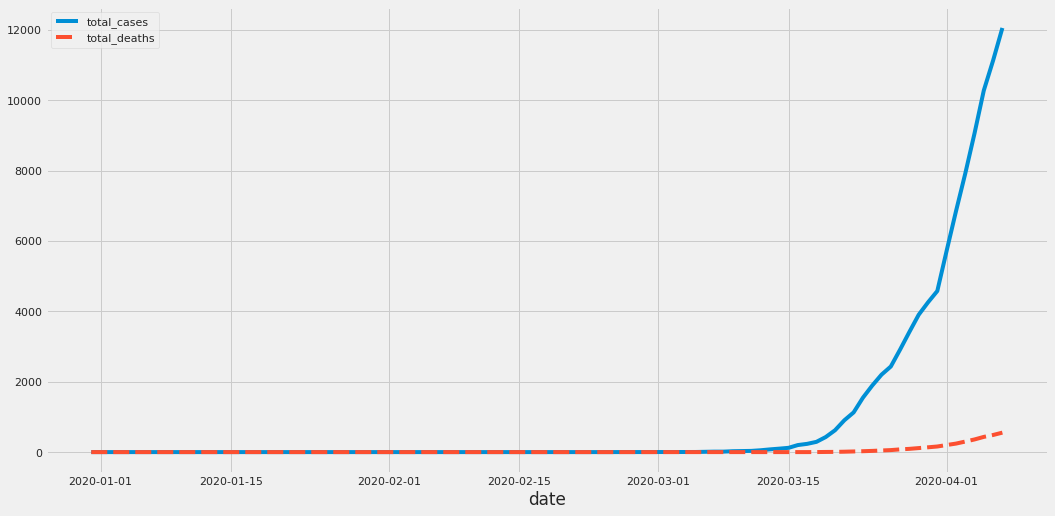

In [18]:
df_data_target['total_cases_ESTIMATED'] = (df_data_target['total_deaths'] / 0.05).shift(-7)
df_data_target['total_cases_ESTIMATED_2'] = 10 * df_data_target['total_cases']

sns.lineplot(data=df_data_target[['total_cases', 'total_deaths']])
df_data_target.tail()

### Substituição de Parâmetros

Se requisitado, vamos substituir alguns dos parâmetros por valores presentes nos dados.

In [19]:
df_data_target[df_data_target['total_cases'] >= 50]['total_cases'].index[0]

Timestamp('2020-03-12 00:00:00')

In [20]:
if infer_parameters_from_data:
    epidemic_start_date = df_data_target[df_data_target['total_cases'] >= 50]['total_cases'].index[0]
    
    first_date_row = df_data_target.loc[epidemic_start_date]
    population_size = first_date_row['population']
    initially_infected = first_date_row['total_cases']
    
    print(f'NEW VALUES: epidemic_start_date={epidemic_start_date}, population_size={population_size}, initially_infected={initially_infected}')
    

NEW VALUES: epidemic_start_date=2020-03-12 00:00:00, population_size=212559409.0, initially_infected=52


Filtremos os dados a partir da data de interesse.

In [21]:
df_data_target = df_data_target[epidemic_start_date:]

## Modelo SEIR

O [modelo SEIR](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) é um dos modos clássicos de se representar a dinâmica de epidemias. Trata-se de um chamado "modelo de compartimento", no qual temos alguns compartimentos principais:

  - S(t): número de indivíduos suscetíveis em função do tempo.
  - E(t): número de expostos, mas ainda não transmissores, em função do tempo.
  - I(t): número de indivíduos infecciosos em função do tempo.
  - R(t): número de indivíduos que se recuperam em função do tempo.
  
São também necessários dois outros parâmetros, que definem taxas de transição entre compartimentos:
  
  - beta: valor entre 0.0 e 1.0 que define a taxa de S para E (i.e., taxa de exposição)
  - alpha: valor entre 0.0 e 1.0 que define a taxa de E para I (i.e., taxa de contaminação)
  - gamma: valor entre 0.0 e 1.0 que define a taxa de I para R (i.e., taxa de recuperação)

Tradicionalmente, esse modelo é tratado via equações diferenciais. Aqui, adotaremos uma implementação via simulações estocásticas, o que nos permitirá posteriormente realizar modificações variadas que talvez não sejam tratáveis analiticamente.

### Funções Auxiliares

Antes de prosseguir, vamos definir algumas funções auxliares que garantirão que os valores acrescidos ou subtraídos nos diversos compartimentos não ultrapassem valores limites.

In [22]:
def aux_enforce_max_addition(Q, delta):
    if Q - delta <= 0:
        return Q
    
    else:
        return delta
    
def aux_enforce_max_removal(Q, delta):
    if Q + delta <= 0:
        return -Q
    else:
        return delta

Ao longo de uma epidemia, é razoável supor que autoridades sanitárias e, de fato, a polulação como um todo, adotarão medidas que possam reduzir o contágio e melhorar as chances de recuperação. Isso pode ser modelado com parâmetros dinâmicos, supondo-se intervenções em momentos precisos do tempo. Assim, os parâmetros do modelo aqui proposto podem ser tanto escalares quanto dicionários que mapeiam instantes a valores naqueles instantes. Para que a simulação possa usar transparentemente qualquer caso, definimos a seguir uma função que extrai o valor do parâmetro conforme o caso.

In [23]:
def param_at(param_var, t):
    if isinstance(param_var, dict):
        return param_var[t]
    
    else:
        return param_var

Convém também ter uma função para montar as sequências de parâmetros (veremos um exemplo mais adiante para entender seu uso).

In [24]:
def dynamic_parameter(regimens, min_length):
    i = 0
    params = {}
    last_value = None
    min_length = int(min_length)
    for value, length in regimens:
        length = int(length)
        param = {t: value for t in range(i, i + length)}
        params.update(param)
        i += length
        last_value = value
    
    # if we do not have enough data, fill in the remaining entries with the last specified value
    if i < min_length:
        param = {t: last_value for t in range(i, i + min_length)}
        params.update(param)

    return params

### Funções dos Compartimentos

Podemos agora definir a dinâmica dos diversos compartimentos contemplados no modelo.

In [25]:
def s(t, S, E, I, R, alpha, beta, gamma):
    delta = aux_enforce_max_removal(S, 
                                    -((param_at(beta, t) * I * S) / population_size))
    
    return delta

In [26]:
def e(t, S, E, I, R, alpha, beta, gamma):
    delta_s = aux_enforce_max_addition(S, 
                                       ((param_at(beta, t) * I * S) / population_size))
    
    delta = aux_enforce_max_removal(E,  
                                    param_at(delta_s, t) - param_at(alpha, t)*E)    
    
        
    return delta

In [27]:
def i(t, S, E, I, R, alpha, beta, gamma):
    delta_e = aux_enforce_max_addition(E, 
                                       param_at(alpha, t)*E)
        
    delta = aux_enforce_max_removal(I, 
                                    param_at(delta_e, t) - param_at(gamma, t)*I)
        
    return delta

In [28]:
def r(t, S, E, I, R, alpha, beta, gamma):
    delta = aux_enforce_max_addition(I,
                                     param_at(gamma, t)*I)
    
    return delta

Também convém poder calcular a variação dos compartimentos E e I para posterior análise.

In [29]:
# how many new patients will be added to E
def e_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_s = aux_enforce_max_addition(S, 
                                       ((param_at(beta, t) * I * S) / population_size))
    
    return delta_s

In [30]:
# how many new patients will be added to I
def i_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_e = aux_enforce_max_addition(E, 
                                       param_at(alpha, t)*E)
    
    return delta_e

In [31]:
# how many new patients will be added to R
def r_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_r = aux_enforce_max_addition(I,
                                     param_at(gamma, t)*I)
    
    return delta_r

### Simulação

A simulação então pode ser definida do seguinte modo.

In [32]:
def simulate(S, E, I, R, alpha, beta, gamma, epidemic_start_date, epidemic_duration_in_days, 
             s_func, e_func, i_func, r_func, e_delta_func, i_delta_func, r_delta_func):
    
    generated_data = [] # initial data
    
    # changes start at 0
    E_delta = 0
    I_delta = 0 
    R_delta = 0
    
    for t in range(0, epidemic_duration_in_days):
        generated_data.append((S, E, E_delta, I, I_delta, R, R_delta))
        
        # main model components
        S_next = S + s_func(t, S, E, I, R, alpha, beta, gamma)
        E_next = E + e_func(t, S, E, I, R, alpha, beta, gamma)
        I_next = I + i_func(t, S, E, I, R, alpha, beta, gamma)
        R_next = R + r_func(t, S, E, I, R, alpha, beta, gamma)
        
        # added information for later analyses
        I_delta = i_delta_func(t, S, E, I, R, alpha, beta, gamma)
        E_delta = e_delta_func(t, S, E, I, R, alpha, beta, gamma)
        R_delta = r_delta_func(t, S, E, I, R, alpha, beta, gamma)

        # lockstep updates
        S = S_next
        E = E_next
        I = I_next
        R = R_next

        assert math.isclose(S + E + I + R, population_size, rel_tol=1e-9, abs_tol=0.0), "Population size must not change."
    
    df = pd.DataFrame(generated_data,
                      columns=['S', 'E', 'E_delta', 'I', 'I_delta', 'R', 'R_delta'],
                      index=pd.date_range(start=epidemic_start_date, periods=epidemic_duration_in_days, freq='D'))
    
    df['E+I'] = df['E'] + df['I']
    df['E+I+R'] = df['E'] + df['I'] + df['R']
    
    return df

Podemos agora simular situações de interesse definindo os parâmetros do modelo.

In [33]:
alpha = 0.9   # E to I rate
beta = 0.8   # S to E rate
gamma = 0.3  # I to R rate

,S,E,E_delta,I,I_delta,R,R_delta,E+I,E+I+R
2020-03-12,2.125594e+08,52.000000,0.000000,0.000000,0.000000,0.000000,0.000000,52.000000,52.000000
2020-03-13,2.125594e+08,5.200000,0.000000,46.800000,46.800000,0.000000,0.000000,52.000000,52.000000
2020-03-14,2.125593e+08,37.959991,37.439991,37.440000,4.680000,14.040000,14.040000,75.399991,89.439991
2020-03-15,2.125593e+08,33.747986,29.951987,60.371992,34.163992,25.272000,11.232000,94.119978,119.391978
2020-03-16,2.125592e+08,51.672365,48.297566,72.633582,30.373188,43.383598,18.111598,124.305947,167.689545


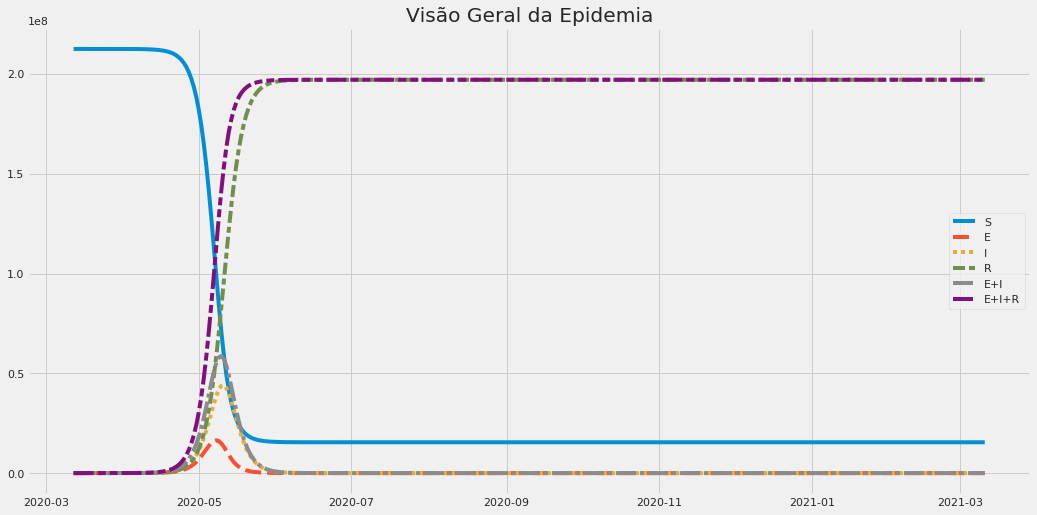

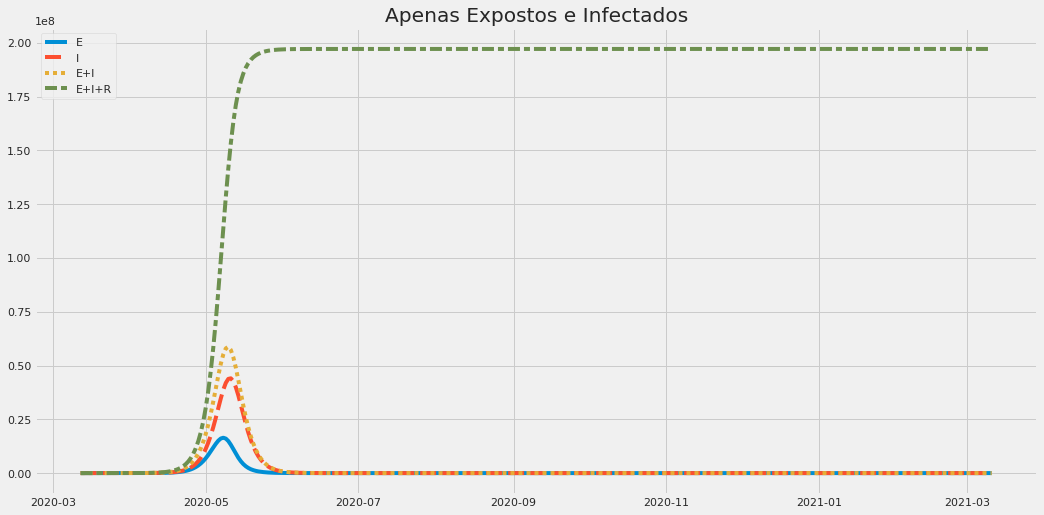

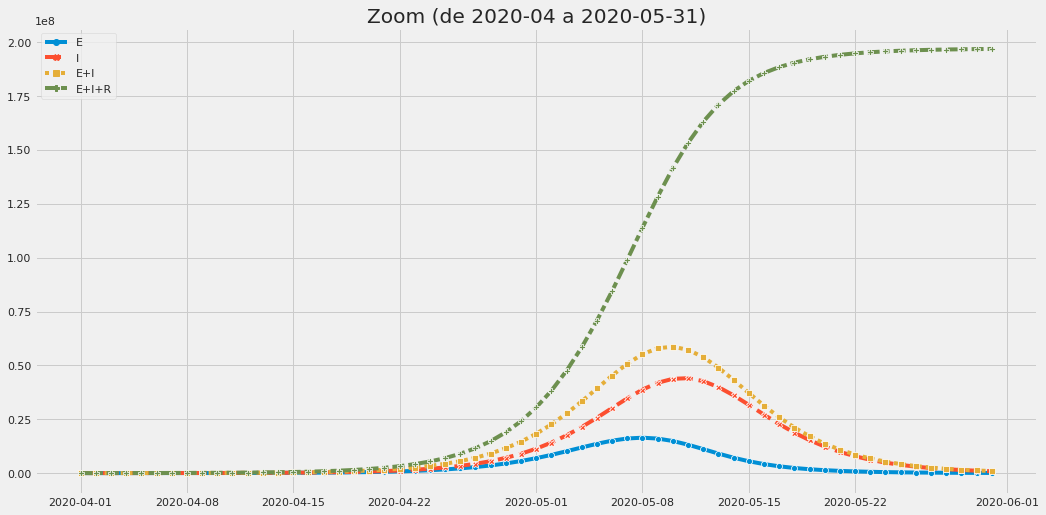

<Figure size 1152x576 with 0 Axes>

In [34]:
df_simulation_data = simulate(S=population_size - initially_infected, 
                              E =initially_infected, 
                              I=0, 
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date,
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e, 
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)

plot_simulation_output(df_simulation_data, zoom_on='2020-04')
df_simulation_data.head()

Como isso se compara visualmente com os dados reais observados?

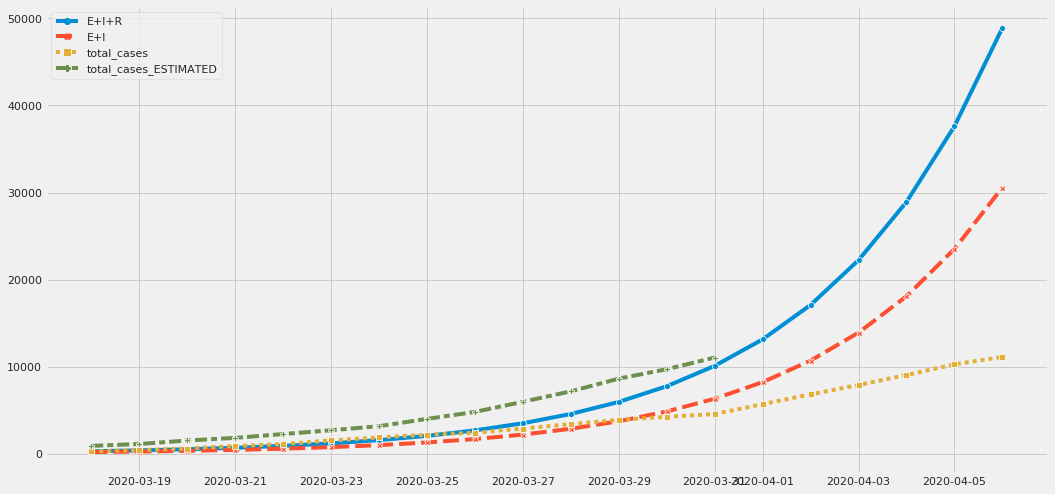

In [35]:
comparison_date = pd.Timestamp.today() - pd.DateOffset(days=1)
df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
sns.lineplot(data=df_simulation_vs_real[['E+I+R', 'E+I', 'total_cases', 'total_cases_ESTIMATED']]\
                                       [comparison_date - pd.DateOffset(days=20):comparison_date], 
             markers=True)

Vejamos um exemplo agora de parâmetro dinâmico. Vamos definir o parâmetro *beta* como 0.3 nos primeiros 30 dias, 0.25 nos 60 dias seguintes e 0.2 daí em diante.

In [36]:
beta = dynamic_parameter([(0.3, 30), 
                          (0.1, 60), 
                          (0.05, epidemic_duration_in_days)], min_length=epidemic_duration_in_days)


,S,E,E_delta,I,I_delta,R,R_delta,E+I,E+I+R
2020-03-12,2.125594e+08,52.000000,0.000000,0.000000,0.000000,0.000000,0.000000,52.000000,52.000000
2020-03-13,2.125594e+08,5.200000,0.000000,46.800000,46.800000,0.000000,0.000000,52.000000,52.000000
2020-03-14,2.125593e+08,14.559997,14.039997,37.440000,4.680000,14.040000,14.040000,51.999997,66.039997
2020-03-15,2.125593e+08,12.687996,11.231997,39.311997,13.103997,25.272000,11.232000,51.999993,77.271993
2020-03-16,2.125593e+08,13.062394,11.793595,38.937594,11.419197,37.065599,11.793599,51.999989,89.065588


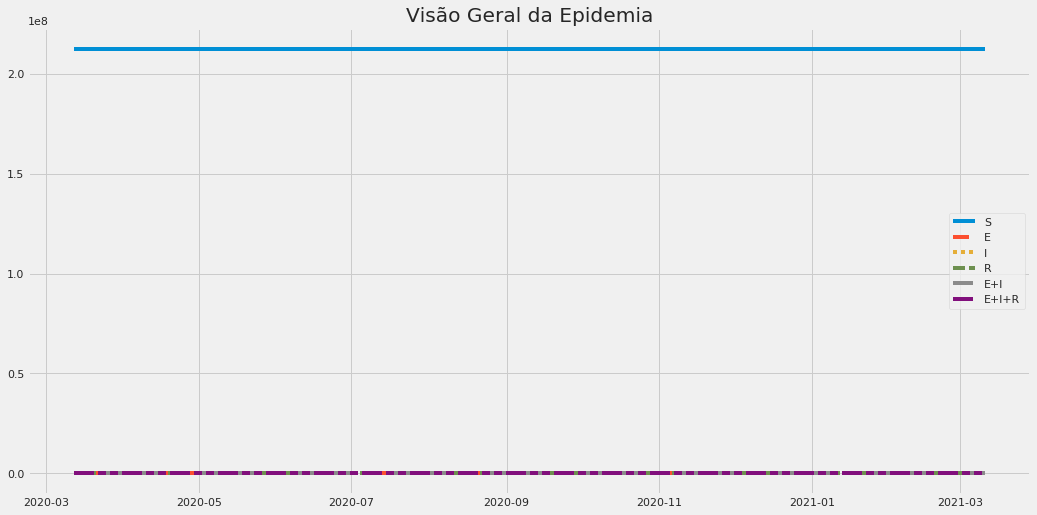

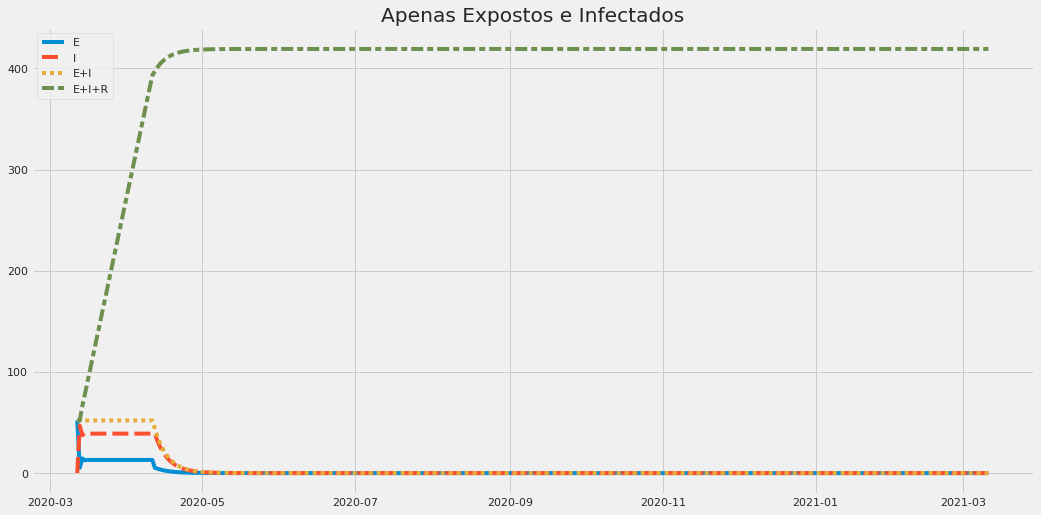

<Figure size 1152x576 with 0 Axes>

In [37]:
df_simulation_data = simulate(S=population_size - initially_infected, 
                              E =initially_infected, 
                              I=0, 
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date,
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e, 
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)

plot_simulation_output(df_simulation_data)
df_simulation_data.head()

## Calibragem de Parâmetros

Podemos agora confrontar os modelos acima com dados reais observados e, assim, encontrar os parâmetros que melhor aproximam a realidade.

Faremos a busca de parâmetros empregando a biblioteca [hyperopt](https://github.com/hyperopt/hyperopt). Para tanto, precisamos definir uma função objetivo a ser otimizada. Aqui, essa função executa uma simulação com os parâmetros (*alpha*, *beta* e *gamma*) sugeridos, obtém a curva de infecções resultante e calcula o erro absoluto médio com relação às datas para as quais temos as observações reais.

In [38]:
def objective_for_simulation(args):
    ##################################################################
    # What kind of parameters we are optimizing? Constant or dynamic?
    ##################################################################
    if 'constant' in args:
        alpha, beta, gamma, t_min, t_max = args['constant']
    elif 'dynamic' in args:
        params_sets, t_min, t_max = args['dynamic'] # TODO
        alpha = []
        beta = []
        gamma = []
        for params in params_sets:
            alpha.append((params['alpha'], int(params['duration'])))
            beta.append((params['beta'], int(params['duration'])))
            gamma.append((params['gamma'], int(params['duration'])))
        
        alpha = dynamic_parameter(alpha, min_length=epidemic_duration_in_days)
        beta = dynamic_parameter(beta, min_length=epidemic_duration_in_days)
        gamma = dynamic_parameter(gamma, min_length=epidemic_duration_in_days)
        
    ###########
    # Simulate
    ###########
    df_simulation_data = simulate(S=population_size - initially_infected, 
                              E=initially_infected,
                              I=0,
                              R=0, 
                              alpha=alpha,beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date, 
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e,  
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)
    
    # run simulation
    df_simulation_data_filtered = df_simulation_data[df_simulation_data.index.isin(df_data_target.index.values)]
    
    ###################
    # Calculate error
    ###################
    df_diff_cases = df_data_target[data_column_to_fit] - \
                               (df_simulation_data_filtered['I'] + df_simulation_data_filtered['E'] + df_simulation_data_filtered['R'])
    
    # we can limit the temporal reach of the estimation if desired
    if t_min is not None and t_max is not None:
        df_diff_cases = df_diff_cases.iloc[t_min:t_max] 
    
    values = df_diff_cases.dropna().values

    mae = np.mean(abs(values)) #mean absolute error

    return mae

### Com Parâmetros Constantes

Suponhamos que os parâmetros do modelo sejam constantes, ou seja, que não haja mudanças de comportamento ou políticas ao longo da epidemia.

Definimos então o espaço de busca dos parâmetros e efetivamente executamos a busca.

In [39]:
#space = {'constant': (hyperopt.hp.uniform('alpha', 0.0, 1.0), hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0), 0, None)}
space = {'constant':(hyperopt.hp.uniform('alpha', 0.99, 1.0), hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0), 0, None)}

trials = hyperopt.Trials()
best = hyperopt.fmin(objective_for_simulation, space, algo=hyperopt.tpe.suggest, max_evals=300, trials=trials)

print("Best parameters found:", best)

  0%|          | 0/300 [00:00<?, ?trial/s, best loss=?]

  2%|▏         | 6/300 [00:00<00:05, 55.20trial/s, best loss: 1004.9714033678123]

  4%|▍         | 12/300 [00:00<00:05, 54.78trial/s, best loss: 1004.9714033678123]

  6%|▌         | 18/300 [00:00<00:05, 54.49trial/s, best loss: 1004.9714033678123]

  8%|▊         | 23/300 [00:00<00:05, 49.63trial/s, best loss: 899.1876357435573] 

  9%|▉         | 27/300 [00:00<00:06, 44.34trial/s, best loss: 899.1876357435573]

 10%|█         | 31/300 [00:00<00:06, 41.23trial/s, best loss: 899.1876357435573]

 12%|█▏        | 35/300 [00:00<00:06, 39.20trial/s, best loss: 899.1876357435573]

 13%|█▎        | 39/300 [00:00<00:06, 37.79trial/s, best loss: 899.1876357435573]

 14%|█▍        | 43/300 [00:01<00:06, 36.73trial/s, best loss: 899.1876357435573]

 16%|█▌        | 47/300 [00:01<00:07, 36.05trial/s, best loss: 899.1876357435573]

 17%|█▋        | 51/300 [00:01<00:06, 36.57trial/s, best loss: 899.1876357435573]

 18%|█▊        | 55/300 [00:01<00:06, 36.13trial/s, best loss: 899.1876357435573]

 20%|█▉        | 59/300 [00:01<00:06, 35.39trial/s, best loss: 899.1876357435573]

 21%|██        | 63/300 [00:01<00:06, 35.05trial/s, best loss: 899.1876357435573]

 22%|██▏       | 67/300 [00:01<00:06, 35.14trial/s, best loss: 899.1876357435573]

 24%|██▎       | 71/300 [00:01<00:06, 35.13trial/s, best loss: 899.1876357435573]

 25%|██▌       | 75/300 [00:01<00:06, 35.12trial/s, best loss: 899.1876357435573]

 26%|██▋       | 79/300 [00:02<00:06, 34.12trial/s, best loss: 884.6898032350189]

 28%|██▊       | 83/300 [00:02<00:06, 33.15trial/s, best loss: 884.6898032350189]

 29%|██▉       | 87/300 [00:02<00:06, 32.55trial/s, best loss: 884.6898032350189]

 30%|███       | 91/300 [00:02<00:06, 32.98trial/s, best loss: 884.6898032350189]

 32%|███▏      | 95/300 [00:02<00:06, 33.45trial/s, best loss: 884.6898032350189]

 33%|███▎      | 99/300 [00:02<00:05, 33.72trial/s, best loss: 884.6898032350189]

 34%|███▍      | 103/300 [00:02<00:05, 34.64trial/s, best loss: 884.6898032350189]

 36%|███▌      | 107/300 [00:02<00:05, 33.80trial/s, best loss: 884.6898032350189]

 37%|███▋      | 111/300 [00:03<00:05, 33.44trial/s, best loss: 884.6898032350189]

 38%|███▊      | 115/300 [00:03<00:05, 33.20trial/s, best loss: 884.6898032350189]

 40%|███▉      | 119/300 [00:03<00:05, 32.78trial/s, best loss: 884.6898032350189]

 41%|████      | 123/300 [00:03<00:05, 32.29trial/s, best loss: 884.6898032350189]

 42%|████▏     | 127/300 [00:03<00:05, 32.37trial/s, best loss: 884.6898032350189]

 44%|████▎     | 131/300 [00:03<00:05, 31.88trial/s, best loss: 884.6898032350189]

 45%|████▌     | 135/300 [00:03<00:05, 31.45trial/s, best loss: 884.6898032350189]

 46%|████▋     | 139/300 [00:03<00:05, 32.20trial/s, best loss: 884.6898032350189]

 48%|████▊     | 143/300 [00:04<00:04, 31.73trial/s, best loss: 884.6898032350189]

 49%|████▉     | 147/300 [00:04<00:04, 31.43trial/s, best loss: 884.6898032350189]

 50%|█████     | 151/300 [00:04<00:04, 30.92trial/s, best loss: 884.6898032350189]

 52%|█████▏    | 155/300 [00:04<00:04, 30.42trial/s, best loss: 884.6898032350189]

 53%|█████▎    | 159/300 [00:04<00:04, 30.16trial/s, best loss: 884.6898032350189]

 54%|█████▍    | 163/300 [00:04<00:04, 31.47trial/s, best loss: 870.8048596627465]

 56%|█████▌    | 167/300 [00:04<00:04, 31.34trial/s, best loss: 870.8048596627465]

 57%|█████▋    | 171/300 [00:04<00:04, 31.34trial/s, best loss: 870.8048596627465]

 58%|█████▊    | 175/300 [00:05<00:04, 31.02trial/s, best loss: 870.8048596627465]

 60%|█████▉    | 179/300 [00:05<00:03, 31.73trial/s, best loss: 870.8048596627465]

 61%|██████    | 183/300 [00:05<00:03, 31.96trial/s, best loss: 870.8048596627465]

 62%|██████▏   | 187/300 [00:05<00:03, 32.07trial/s, best loss: 870.8048596627465]

 64%|██████▎   | 191/300 [00:05<00:03, 31.63trial/s, best loss: 870.8048596627465]

 65%|██████▌   | 195/300 [00:05<00:03, 31.28trial/s, best loss: 870.8048596627465]

 66%|██████▋   | 199/300 [00:05<00:03, 30.52trial/s, best loss: 870.8048596627465]

 68%|██████▊   | 203/300 [00:05<00:03, 30.96trial/s, best loss: 860.632317568911] 

 69%|██████▉   | 207/300 [00:06<00:03, 30.81trial/s, best loss: 860.632317568911]

 70%|███████   | 211/300 [00:06<00:02, 30.69trial/s, best loss: 860.632317568911]

 72%|███████▏  | 215/300 [00:06<00:02, 29.95trial/s, best loss: 860.632317568911]

 73%|███████▎  | 219/300 [00:06<00:02, 29.94trial/s, best loss: 860.632317568911]

 74%|███████▍  | 222/300 [00:06<00:02, 29.53trial/s, best loss: 860.632317568911]

 75%|███████▌  | 225/300 [00:06<00:02, 29.07trial/s, best loss: 860.632317568911]

 76%|███████▌  | 228/300 [00:06<00:02, 28.69trial/s, best loss: 860.632317568911]

 77%|███████▋  | 231/300 [00:06<00:02, 28.95trial/s, best loss: 860.632317568911]

 78%|███████▊  | 235/300 [00:07<00:02, 30.22trial/s, best loss: 860.632317568911]

 80%|███████▉  | 239/300 [00:07<00:02, 29.99trial/s, best loss: 860.632317568911]

 81%|████████  | 243/300 [00:07<00:01, 29.34trial/s, best loss: 860.632317568911]

 82%|████████▏ | 246/300 [00:07<00:01, 29.34trial/s, best loss: 860.632317568911]

 83%|████████▎ | 250/300 [00:07<00:01, 29.94trial/s, best loss: 860.632317568911]

 85%|████████▍ | 254/300 [00:07<00:01, 29.81trial/s, best loss: 860.632317568911]

 86%|████████▌ | 257/300 [00:07<00:01, 29.53trial/s, best loss: 860.632317568911]

 87%|████████▋ | 261/300 [00:07<00:01, 29.46trial/s, best loss: 860.632317568911]

 88%|████████▊ | 264/300 [00:08<00:01, 28.08trial/s, best loss: 860.632317568911]

 89%|████████▉ | 267/300 [00:08<00:01, 25.36trial/s, best loss: 840.7335147439162]

 90%|█████████ | 270/300 [00:08<00:01, 25.75trial/s, best loss: 840.7335147439162]

 91%|█████████ | 273/300 [00:08<00:01, 26.27trial/s, best loss: 840.7335147439162]

 92%|█████████▏| 276/300 [00:08<00:01, 20.61trial/s, best loss: 840.7335147439162]

 93%|█████████▎| 279/300 [00:08<00:00, 22.46trial/s, best loss: 840.7335147439162]

 94%|█████████▍| 282/300 [00:08<00:00, 23.81trial/s, best loss: 840.7335147439162]

 95%|█████████▌| 285/300 [00:08<00:00, 24.75trial/s, best loss: 840.7335147439162]

 96%|█████████▌| 288/300 [00:09<00:00, 25.65trial/s, best loss: 840.7335147439162]

 97%|█████████▋| 291/300 [00:09<00:00, 26.12trial/s, best loss: 840.7335147439162]

 98%|█████████▊| 294/300 [00:09<00:00, 26.72trial/s, best loss: 840.7335147439162]

 99%|█████████▉| 297/300 [00:09<00:00, 27.08trial/s, best loss: 840.7335147439162]

100%|██████████| 300/300 [00:09<00:00, 27.26trial/s, best loss: 840.7335147439162]

100%|██████████| 300/300 [00:09<00:00, 31.61trial/s, best loss: 840.7335147439162]


Best parameters found: {'alpha': 0.9985427227954915, 'beta': 0.9994640613543382, 'gamma': 0.4539562361789474}


In [40]:
#trials.losses()
#pd.Series(trials.losses()).plot(title='Loss during optimiztion')

Podemos então executar o modelo com os parâmetros encontrados e examinar as curvas de progressão da epidemia.

,S,E,E_delta,I,I_delta,R,R_delta,E+I,E+I+R
2020-03-16,2.125592e+08,67.349486,67.307970,65.220255,28.447427,67.047925,30.571276,132.569742,199.617666
2020-03-17,2.125591e+08,65.283387,65.185240,102.864453,67.251340,96.655066,29.607141,168.147840,264.802906
2020-03-18,2.125590e+08,102.904332,102.809196,121.356744,65.188251,143.351026,46.695960,224.261076,367.612102
2020-03-19,2.125589e+08,121.441454,121.291494,169.020465,102.754372,198.441677,55.090651,290.461919,488.903596
2020-03-20,2.125588e+08,169.106466,168.929492,213.557051,121.264481,275.169571,76.727894,382.663517,657.833088


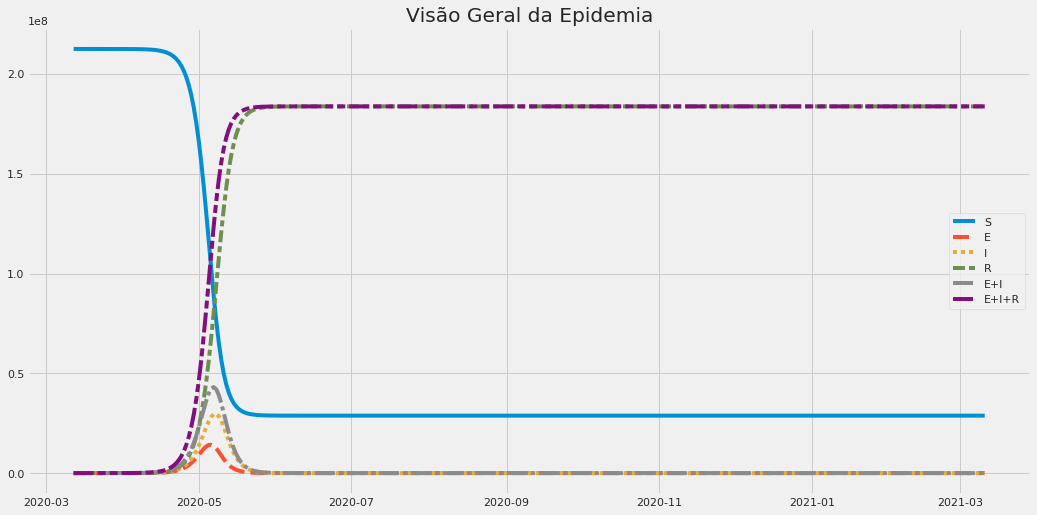

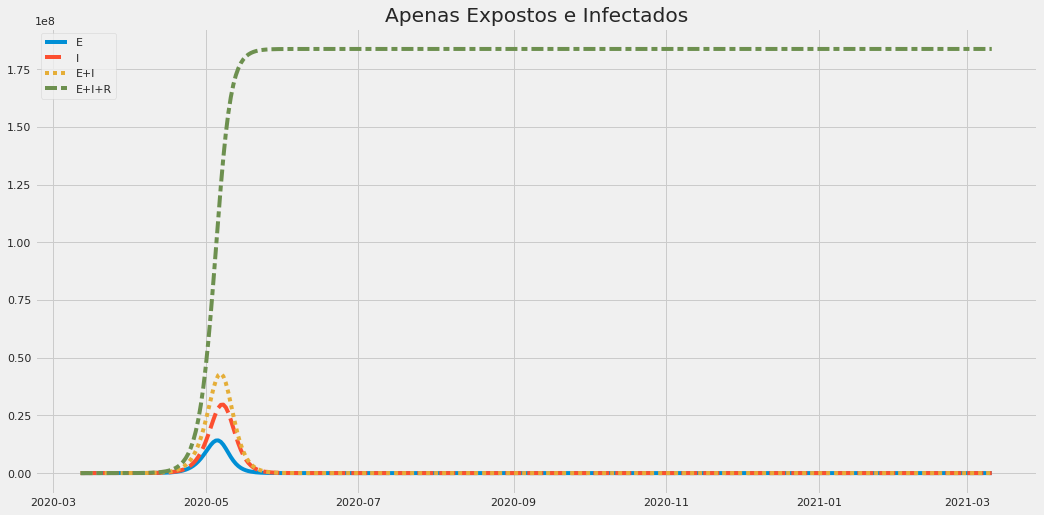

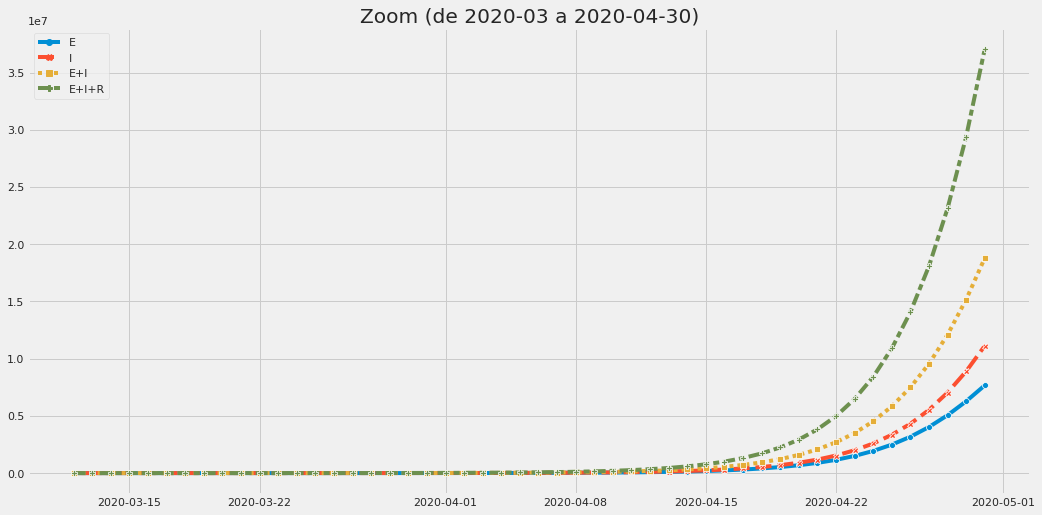

<Figure size 1152x576 with 0 Axes>

In [41]:
alpha = best['alpha']
beta  = best['beta']
gamma = best['gamma']

df_simulation_data = simulate(S=population_size - initially_infected, 
                              E=initially_infected,
                              I=0,
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date, 
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e,
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)

plot_simulation_output(df_simulation_data, zoom_on='2020-03', file_name='constant')
df_simulation_data['2020-03-16':'2020-05-01'].head()

Como isso se compara visualmente com os dados reais observados?

In [42]:
df_data_target.tail()

,new_cases,new_deaths,total_cases,total_deaths,countriesAndTerritories,continent,population_year,population,total_cases_ESTIMATED,total_cases_ESTIMATED_2
date,,,,,,,,,,
2020-04-03,1074,58,7910,299,Brazil,South America,2020.0,212559409.0,NaN,79100
2020-04-04,1146,60,9056,359,Brazil,South America,2020.0,212559409.0,NaN,90560
2020-04-05,1222,73,10278,432,Brazil,South America,2020.0,212559409.0,NaN,102780
2020-04-06,852,54,11130,486,Brazil,South America,2020.0,212559409.0,NaN,111300
2020-04-07,926,67,12056,553,Brazil,South America,2020.0,212559409.0,NaN,120560


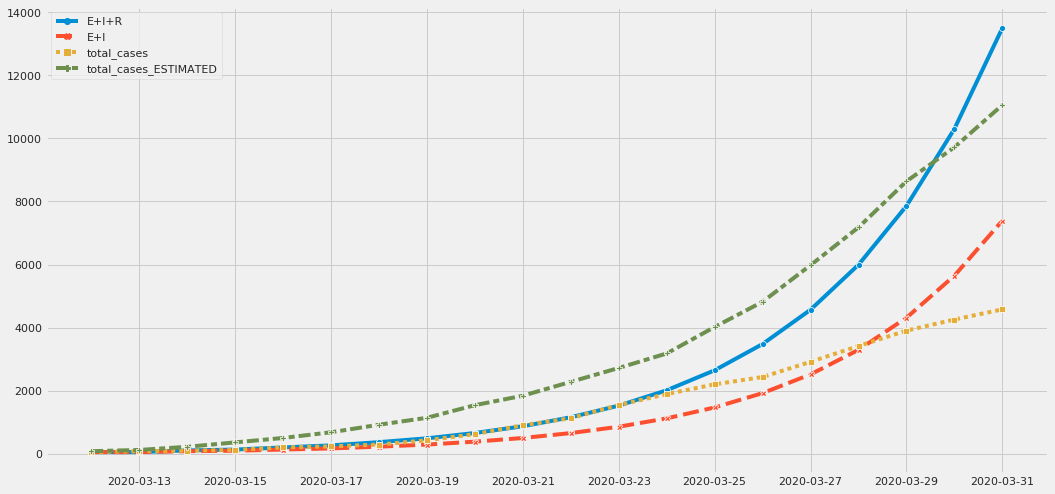

In [43]:
comparison_date = pd.Timestamp.today() - pd.DateOffset(days=7)
df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
sns.lineplot(data=df_simulation_vs_real[['E+I+R', 'E+I', 'total_cases', 'total_cases_ESTIMATED']]\
                                       [comparison_date - pd.DateOffset(days=20):comparison_date], 
             markers=True)

Salvemos os resultados.

In [44]:
df_simulation_data.to_csv(results_folder + f'seir_model_output.{target_location.lower()}.csv')

### Com Parâmetros Dinâmicos

Vamos experimentar agora introduzindo a possibilidade de aprender medidas de mitigação após o início do surto. Ou seja, experimentaremos com dois grupos de parâmetros: aqueles *antes* das medidas, e aqueles *depois* das medidas. Esses dois conjuntos de parâmetros serão estimados a partir dos dados fornecidos.

In [45]:
space = \
    {'dynamic':\
        ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.0, 1.0), 
           'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
           'duration': hyperopt.hp.uniform('duration_1', 10.0, 30.0)}, 
           {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.0, 1.0), 
           'gamma': hyperopt.hp.uniform('gamma_2', 0.0, 1.0),
           'duration': hyperopt.hp.uniform('duration_2', 0.0, 30.0)}], 
        0, None)
    }

trials = hyperopt.Trials()
best = hyperopt.fmin(objective_for_simulation, space, algo=hyperopt.tpe.suggest, max_evals=1500, trials=trials)

print("Best parameters found:", best)

  0%|          | 0/1500 [00:00<?, ?trial/s, best loss=?]

  0%|          | 4/1500 [00:00<00:37, 39.75trial/s, best loss: 1226.308128295434]

  1%|          | 8/1500 [00:00<00:39, 37.69trial/s, best loss: 1226.308128295434]

  1%|          | 12/1500 [00:00<00:39, 37.72trial/s, best loss: 1226.308128295434]

  1%|          | 16/1500 [00:00<00:38, 38.16trial/s, best loss: 1226.308128295434]

  1%|▏         | 21/1500 [00:00<00:40, 36.65trial/s, best loss: 795.2162171971481]

  2%|▏         | 25/1500 [00:00<00:51, 28.54trial/s, best loss: 768.4603603488596]

  2%|▏         | 28/1500 [00:00<01:03, 23.06trial/s, best loss: 737.81387078768]  

  2%|▏         | 31/1500 [00:01<01:08, 21.56trial/s, best loss: 737.81387078768]

  2%|▏         | 34/1500 [00:01<01:11, 20.49trial/s, best loss: 737.81387078768]

  2%|▏         | 37/1500 [00:01<01:13, 20.00trial/s, best loss: 737.81387078768]

  3%|▎         | 40/1500 [00:01<01:14, 19.52trial/s, best loss: 733.7571640508183]

  3%|▎         | 42/1500 [00:01<01:16, 19.11trial/s, best loss: 733.7571640508183]

  3%|▎         | 44/1500 [00:01<01:16, 18.93trial/s, best loss: 733.7571640508183]

  3%|▎         | 46/1500 [00:01<01:17, 18.79trial/s, best loss: 733.7571640508183]

  3%|▎         | 48/1500 [00:02<01:17, 18.77trial/s, best loss: 733.7571640508183]

  3%|▎         | 50/1500 [00:02<01:17, 18.71trial/s, best loss: 733.7571640508183]

  3%|▎         | 52/1500 [00:02<01:17, 18.68trial/s, best loss: 733.7571640508183]

  4%|▎         | 54/1500 [00:02<01:18, 18.37trial/s, best loss: 733.7571640508183]

  4%|▎         | 56/1500 [00:02<01:18, 18.51trial/s, best loss: 733.7571640508183]

  4%|▍         | 58/1500 [00:02<01:18, 18.38trial/s, best loss: 733.7571640508183]

  4%|▍         | 60/1500 [00:02<01:18, 18.38trial/s, best loss: 733.7571640508183]

  4%|▍         | 62/1500 [00:02<01:18, 18.27trial/s, best loss: 733.7571640508183]

  4%|▍         | 64/1500 [00:02<01:17, 18.41trial/s, best loss: 733.7571640508183]

  4%|▍         | 66/1500 [00:03<01:17, 18.48trial/s, best loss: 733.7571640508183]

  5%|▍         | 68/1500 [00:03<01:17, 18.46trial/s, best loss: 733.7571640508183]

  5%|▍         | 70/1500 [00:03<01:16, 18.66trial/s, best loss: 733.7571640508183]

  5%|▍         | 72/1500 [00:03<01:15, 18.84trial/s, best loss: 733.7571640508183]

  5%|▍         | 74/1500 [00:03<01:16, 18.63trial/s, best loss: 733.7571640508183]

  5%|▌         | 76/1500 [00:03<01:15, 18.94trial/s, best loss: 733.7571640508183]

  5%|▌         | 78/1500 [00:03<01:14, 19.05trial/s, best loss: 733.7571640508183]

  5%|▌         | 80/1500 [00:03<01:14, 19.02trial/s, best loss: 398.11290930303335]

  5%|▌         | 82/1500 [00:03<01:14, 19.02trial/s, best loss: 398.11290930303335]

  6%|▌         | 84/1500 [00:03<01:14, 18.90trial/s, best loss: 398.11290930303335]

  6%|▌         | 86/1500 [00:04<01:15, 18.84trial/s, best loss: 398.11290930303335]

  6%|▌         | 88/1500 [00:04<01:15, 18.64trial/s, best loss: 398.11290930303335]

  6%|▌         | 90/1500 [00:04<01:17, 18.27trial/s, best loss: 398.11290930303335]

  6%|▌         | 92/1500 [00:04<01:16, 18.33trial/s, best loss: 398.11290930303335]

  6%|▋         | 94/1500 [00:04<01:38, 14.24trial/s, best loss: 398.11290930303335]

  6%|▋         | 96/1500 [00:04<01:33, 15.07trial/s, best loss: 398.11290930303335]

  7%|▋         | 98/1500 [00:04<01:29, 15.72trial/s, best loss: 398.11290930303335]

  7%|▋         | 100/1500 [00:04<01:25, 16.30trial/s, best loss: 398.11290930303335]

  7%|▋         | 102/1500 [00:05<01:24, 16.55trial/s, best loss: 398.11290930303335]

  7%|▋         | 104/1500 [00:05<01:23, 16.71trial/s, best loss: 398.11290930303335]

  7%|▋         | 106/1500 [00:05<01:22, 16.92trial/s, best loss: 398.11290930303335]

  7%|▋         | 108/1500 [00:05<01:20, 17.19trial/s, best loss: 398.11290930303335]

  7%|▋         | 110/1500 [00:05<01:21, 17.09trial/s, best loss: 398.11290930303335]

  7%|▋         | 112/1500 [00:05<01:21, 16.96trial/s, best loss: 398.11290930303335]

  8%|▊         | 114/1500 [00:05<01:21, 17.00trial/s, best loss: 398.11290930303335]

  8%|▊         | 116/1500 [00:05<01:21, 17.01trial/s, best loss: 398.11290930303335]

  8%|▊         | 118/1500 [00:06<01:20, 17.07trial/s, best loss: 398.11290930303335]

  8%|▊         | 120/1500 [00:06<01:24, 16.41trial/s, best loss: 398.11290930303335]

  8%|▊         | 122/1500 [00:06<01:22, 16.69trial/s, best loss: 398.11290930303335]

  8%|▊         | 124/1500 [00:06<01:20, 17.05trial/s, best loss: 398.11290930303335]

  8%|▊         | 126/1500 [00:06<01:19, 17.21trial/s, best loss: 398.11290930303335]

  9%|▊         | 128/1500 [00:06<01:18, 17.43trial/s, best loss: 398.11290930303335]

  9%|▊         | 130/1500 [00:06<01:19, 17.31trial/s, best loss: 398.11290930303335]

  9%|▉         | 132/1500 [00:06<01:19, 17.20trial/s, best loss: 398.11290930303335]

  9%|▉         | 134/1500 [00:06<01:19, 17.18trial/s, best loss: 398.11290930303335]

  9%|▉         | 136/1500 [00:07<01:18, 17.38trial/s, best loss: 398.11290930303335]

  9%|▉         | 138/1500 [00:07<01:18, 17.31trial/s, best loss: 398.11290930303335]

  9%|▉         | 140/1500 [00:07<01:19, 17.17trial/s, best loss: 398.11290930303335]

  9%|▉         | 142/1500 [00:07<01:19, 17.00trial/s, best loss: 398.11290930303335]

 10%|▉         | 144/1500 [00:07<01:19, 17.05trial/s, best loss: 398.11290930303335]

 10%|▉         | 146/1500 [00:07<01:19, 17.02trial/s, best loss: 398.11290930303335]

 10%|▉         | 148/1500 [00:07<01:19, 17.07trial/s, best loss: 398.11290930303335]

 10%|█         | 150/1500 [00:07<01:22, 16.46trial/s, best loss: 398.11290930303335]

 10%|█         | 152/1500 [00:08<01:22, 16.38trial/s, best loss: 398.11290930303335]

 10%|█         | 154/1500 [00:08<01:20, 16.65trial/s, best loss: 398.11290930303335]

 10%|█         | 156/1500 [00:08<01:19, 16.97trial/s, best loss: 398.11290930303335]

 11%|█         | 158/1500 [00:08<01:18, 17.03trial/s, best loss: 398.11290930303335]

 11%|█         | 160/1500 [00:08<01:18, 17.06trial/s, best loss: 398.11290930303335]

 11%|█         | 162/1500 [00:08<01:17, 17.16trial/s, best loss: 398.11290930303335]

 11%|█         | 164/1500 [00:08<01:18, 17.04trial/s, best loss: 398.11290930303335]

 11%|█         | 166/1500 [00:08<01:17, 17.12trial/s, best loss: 398.11290930303335]

 11%|█         | 168/1500 [00:08<01:16, 17.30trial/s, best loss: 398.11290930303335]

 11%|█▏        | 170/1500 [00:09<01:24, 15.70trial/s, best loss: 398.11290930303335]

 11%|█▏        | 172/1500 [00:09<01:26, 15.43trial/s, best loss: 398.11290930303335]

 12%|█▏        | 174/1500 [00:09<01:27, 15.20trial/s, best loss: 398.11290930303335]

 12%|█▏        | 176/1500 [00:09<01:28, 15.02trial/s, best loss: 398.11290930303335]

 12%|█▏        | 178/1500 [00:09<01:24, 15.60trial/s, best loss: 398.11290930303335]

 12%|█▏        | 180/1500 [00:09<01:22, 16.08trial/s, best loss: 398.11290930303335]

 12%|█▏        | 182/1500 [00:09<01:20, 16.41trial/s, best loss: 398.11290930303335]

 12%|█▏        | 184/1500 [00:09<01:19, 16.49trial/s, best loss: 398.11290930303335]

 12%|█▏        | 186/1500 [00:10<01:19, 16.60trial/s, best loss: 398.11290930303335]

 13%|█▎        | 188/1500 [00:10<01:19, 16.46trial/s, best loss: 398.11290930303335]

 13%|█▎        | 190/1500 [00:10<01:19, 16.49trial/s, best loss: 398.11290930303335]

 13%|█▎        | 192/1500 [00:10<01:19, 16.47trial/s, best loss: 398.11290930303335]

 13%|█▎        | 194/1500 [00:10<01:19, 16.39trial/s, best loss: 398.11290930303335]

 13%|█▎        | 196/1500 [00:10<01:20, 16.24trial/s, best loss: 398.11290930303335]

 13%|█▎        | 198/1500 [00:10<01:19, 16.32trial/s, best loss: 398.11290930303335]

 13%|█▎        | 200/1500 [00:10<01:19, 16.25trial/s, best loss: 398.11290930303335]

 13%|█▎        | 202/1500 [00:11<01:19, 16.34trial/s, best loss: 398.11290930303335]

 14%|█▎        | 204/1500 [00:11<01:19, 16.24trial/s, best loss: 398.11290930303335]

 14%|█▎        | 206/1500 [00:11<01:19, 16.18trial/s, best loss: 398.11290930303335]

 14%|█▍        | 208/1500 [00:11<01:19, 16.34trial/s, best loss: 398.11290930303335]

 14%|█▍        | 210/1500 [00:11<01:24, 15.27trial/s, best loss: 398.11290930303335]

 14%|█▍        | 212/1500 [00:11<01:29, 14.36trial/s, best loss: 398.11290930303335]

 14%|█▍        | 214/1500 [00:11<01:26, 14.83trial/s, best loss: 398.11290930303335]

 14%|█▍        | 216/1500 [00:12<01:25, 14.97trial/s, best loss: 398.11290930303335]

 15%|█▍        | 218/1500 [00:12<01:21, 15.65trial/s, best loss: 398.11290930303335]

 15%|█▍        | 220/1500 [00:12<01:19, 16.14trial/s, best loss: 398.11290930303335]

 15%|█▍        | 222/1500 [00:12<01:17, 16.46trial/s, best loss: 398.11290930303335]

 15%|█▍        | 224/1500 [00:12<01:17, 16.49trial/s, best loss: 398.11290930303335]

 15%|█▌        | 226/1500 [00:12<01:16, 16.57trial/s, best loss: 398.11290930303335]

 15%|█▌        | 228/1500 [00:12<01:17, 16.49trial/s, best loss: 398.11290930303335]

 15%|█▌        | 230/1500 [00:12<01:16, 16.51trial/s, best loss: 398.11290930303335]

 15%|█▌        | 232/1500 [00:13<01:32, 13.71trial/s, best loss: 398.11290930303335]

 16%|█▌        | 234/1500 [00:13<01:26, 14.55trial/s, best loss: 398.11290930303335]

 16%|█▌        | 236/1500 [00:13<01:23, 15.12trial/s, best loss: 398.11290930303335]

 16%|█▌        | 238/1500 [00:13<01:20, 15.62trial/s, best loss: 398.11290930303335]

 16%|█▌        | 240/1500 [00:13<01:18, 16.15trial/s, best loss: 398.11290930303335]

 16%|█▌        | 242/1500 [00:13<01:17, 16.29trial/s, best loss: 398.11290930303335]

 16%|█▋        | 244/1500 [00:13<01:16, 16.46trial/s, best loss: 398.11290930303335]

 16%|█▋        | 246/1500 [00:13<01:16, 16.44trial/s, best loss: 398.11290930303335]

 17%|█▋        | 248/1500 [00:14<01:15, 16.48trial/s, best loss: 398.11290930303335]

 17%|█▋        | 250/1500 [00:14<01:15, 16.57trial/s, best loss: 398.11290930303335]

 17%|█▋        | 252/1500 [00:14<01:14, 16.78trial/s, best loss: 398.11290930303335]

 17%|█▋        | 254/1500 [00:14<01:16, 16.29trial/s, best loss: 398.11290930303335]

 17%|█▋        | 256/1500 [00:14<01:16, 16.28trial/s, best loss: 398.11290930303335]

 17%|█▋        | 258/1500 [00:14<01:16, 16.32trial/s, best loss: 398.11290930303335]

 17%|█▋        | 260/1500 [00:14<01:16, 16.31trial/s, best loss: 398.11290930303335]

 17%|█▋        | 262/1500 [00:14<01:15, 16.42trial/s, best loss: 398.11290930303335]

 18%|█▊        | 264/1500 [00:14<01:14, 16.62trial/s, best loss: 398.11290930303335]

 18%|█▊        | 266/1500 [00:15<01:14, 16.58trial/s, best loss: 398.11290930303335]

 18%|█▊        | 268/1500 [00:15<01:14, 16.51trial/s, best loss: 398.11290930303335]

 18%|█▊        | 270/1500 [00:15<01:15, 16.38trial/s, best loss: 398.11290930303335]

 18%|█▊        | 272/1500 [00:15<01:15, 16.33trial/s, best loss: 398.11290930303335]

 18%|█▊        | 274/1500 [00:15<01:14, 16.42trial/s, best loss: 398.11290930303335]

 18%|█▊        | 276/1500 [00:15<01:18, 15.50trial/s, best loss: 398.11290930303335]

 19%|█▊        | 278/1500 [00:15<01:18, 15.60trial/s, best loss: 398.11290930303335]

 19%|█▊        | 280/1500 [00:16<01:19, 15.35trial/s, best loss: 398.11290930303335]

 19%|█▉        | 282/1500 [00:16<01:16, 15.87trial/s, best loss: 398.11290930303335]

 19%|█▉        | 284/1500 [00:16<01:16, 15.98trial/s, best loss: 398.11290930303335]

 19%|█▉        | 286/1500 [00:16<01:16, 15.89trial/s, best loss: 398.11290930303335]

 19%|█▉        | 288/1500 [00:16<01:15, 15.99trial/s, best loss: 398.11290930303335]

 19%|█▉        | 290/1500 [00:16<01:14, 16.14trial/s, best loss: 398.11290930303335]

 19%|█▉        | 292/1500 [00:16<01:14, 16.12trial/s, best loss: 398.11290930303335]

 20%|█▉        | 294/1500 [00:16<01:18, 15.43trial/s, best loss: 398.11290930303335]

 20%|█▉        | 296/1500 [00:16<01:16, 15.84trial/s, best loss: 398.11290930303335]

 20%|█▉        | 298/1500 [00:17<01:14, 16.18trial/s, best loss: 398.11290930303335]

 20%|██        | 300/1500 [00:17<01:14, 16.16trial/s, best loss: 398.11290930303335]

 20%|██        | 302/1500 [00:17<01:13, 16.41trial/s, best loss: 398.11290930303335]

 20%|██        | 304/1500 [00:17<01:12, 16.39trial/s, best loss: 398.11290930303335]

 20%|██        | 306/1500 [00:17<01:12, 16.39trial/s, best loss: 379.5249023435285] 

 21%|██        | 308/1500 [00:17<01:13, 16.30trial/s, best loss: 379.5249023435285]

 21%|██        | 310/1500 [00:17<01:13, 16.14trial/s, best loss: 379.5249023435285]

 21%|██        | 312/1500 [00:17<01:13, 16.07trial/s, best loss: 379.5249023435285]

 21%|██        | 314/1500 [00:18<01:14, 15.95trial/s, best loss: 379.5249023435285]

 21%|██        | 316/1500 [00:18<01:13, 16.04trial/s, best loss: 379.5249023435285]

 21%|██        | 318/1500 [00:18<01:14, 15.95trial/s, best loss: 379.5249023435285]

 21%|██▏       | 320/1500 [00:18<01:13, 16.11trial/s, best loss: 379.5249023435285]

 21%|██▏       | 322/1500 [00:18<01:13, 16.12trial/s, best loss: 379.5249023435285]

 22%|██▏       | 324/1500 [00:18<01:12, 16.13trial/s, best loss: 379.5249023435285]

 22%|██▏       | 326/1500 [00:18<01:13, 16.07trial/s, best loss: 379.5249023435285]

 22%|██▏       | 328/1500 [00:18<01:12, 16.16trial/s, best loss: 379.5249023435285]

 22%|██▏       | 330/1500 [00:19<01:13, 15.99trial/s, best loss: 379.5249023435285]

 22%|██▏       | 332/1500 [00:19<01:13, 15.88trial/s, best loss: 379.5249023435285]

 22%|██▏       | 334/1500 [00:19<01:13, 15.83trial/s, best loss: 379.5249023435285]

 22%|██▏       | 336/1500 [00:19<01:13, 15.87trial/s, best loss: 379.5249023435285]

 23%|██▎       | 338/1500 [00:19<01:14, 15.64trial/s, best loss: 379.5249023435285]

 23%|██▎       | 340/1500 [00:19<01:18, 14.82trial/s, best loss: 379.5249023435285]

 23%|██▎       | 342/1500 [00:19<01:23, 13.85trial/s, best loss: 379.5249023435285]

 23%|██▎       | 344/1500 [00:20<01:20, 14.33trial/s, best loss: 379.5249023435285]

 23%|██▎       | 346/1500 [00:20<01:18, 14.69trial/s, best loss: 379.5249023435285]

 23%|██▎       | 348/1500 [00:20<01:17, 14.92trial/s, best loss: 379.5249023435285]

 23%|██▎       | 350/1500 [00:20<01:16, 15.05trial/s, best loss: 379.5249023435285]

 23%|██▎       | 352/1500 [00:20<01:16, 15.09trial/s, best loss: 379.5249023435285]

 24%|██▎       | 354/1500 [00:20<01:14, 15.30trial/s, best loss: 379.5249023435285]

 24%|██▎       | 356/1500 [00:20<01:14, 15.27trial/s, best loss: 379.5249023435285]

 24%|██▍       | 358/1500 [00:20<01:14, 15.29trial/s, best loss: 379.5249023435285]

 24%|██▍       | 360/1500 [00:21<01:18, 14.57trial/s, best loss: 379.5249023435285]

 24%|██▍       | 362/1500 [00:21<01:19, 14.40trial/s, best loss: 379.5249023435285]

 24%|██▍       | 364/1500 [00:21<01:17, 14.74trial/s, best loss: 379.5249023435285]

 24%|██▍       | 366/1500 [00:21<01:15, 14.98trial/s, best loss: 379.5249023435285]

 25%|██▍       | 368/1500 [00:21<01:14, 15.17trial/s, best loss: 379.5249023435285]

 25%|██▍       | 370/1500 [00:21<01:13, 15.35trial/s, best loss: 379.5249023435285]

 25%|██▍       | 372/1500 [00:21<01:23, 13.46trial/s, best loss: 379.5249023435285]

 25%|██▍       | 374/1500 [00:22<01:20, 14.06trial/s, best loss: 379.5249023435285]

 25%|██▌       | 376/1500 [00:22<01:18, 14.39trial/s, best loss: 379.5249023435285]

 25%|██▌       | 378/1500 [00:22<01:16, 14.58trial/s, best loss: 379.5249023435285]

 25%|██▌       | 380/1500 [00:22<01:15, 14.84trial/s, best loss: 379.5249023435285]

 25%|██▌       | 382/1500 [00:22<01:14, 15.07trial/s, best loss: 379.5249023435285]

 26%|██▌       | 384/1500 [00:22<01:13, 15.26trial/s, best loss: 379.5249023435285]

 26%|██▌       | 386/1500 [00:22<01:12, 15.47trial/s, best loss: 379.5249023435285]

 26%|██▌       | 388/1500 [00:22<01:12, 15.32trial/s, best loss: 379.5249023435285]

 26%|██▌       | 390/1500 [00:23<01:12, 15.35trial/s, best loss: 379.5249023435285]

 26%|██▌       | 392/1500 [00:23<01:12, 15.20trial/s, best loss: 379.5249023435285]

 26%|██▋       | 394/1500 [00:23<01:12, 15.20trial/s, best loss: 379.5249023435285]

 26%|██▋       | 396/1500 [00:23<01:12, 15.29trial/s, best loss: 379.5249023435285]

 27%|██▋       | 398/1500 [00:23<01:11, 15.37trial/s, best loss: 379.5249023435285]

 27%|██▋       | 400/1500 [00:23<01:11, 15.31trial/s, best loss: 379.5249023435285]

 27%|██▋       | 402/1500 [00:23<01:11, 15.27trial/s, best loss: 379.5249023435285]

 27%|██▋       | 404/1500 [00:24<01:11, 15.36trial/s, best loss: 379.5249023435285]

 27%|██▋       | 406/1500 [00:24<01:11, 15.35trial/s, best loss: 379.5249023435285]

 27%|██▋       | 408/1500 [00:24<01:12, 15.14trial/s, best loss: 379.5249023435285]

 27%|██▋       | 410/1500 [00:24<01:11, 15.17trial/s, best loss: 379.5249023435285]

 27%|██▋       | 412/1500 [00:24<01:11, 15.27trial/s, best loss: 379.5249023435285]

 28%|██▊       | 414/1500 [00:24<01:11, 15.18trial/s, best loss: 379.5249023435285]

 28%|██▊       | 416/1500 [00:24<01:11, 15.17trial/s, best loss: 379.5249023435285]

 28%|██▊       | 418/1500 [00:24<01:11, 15.16trial/s, best loss: 379.5249023435285]

 28%|██▊       | 420/1500 [00:25<01:12, 14.98trial/s, best loss: 379.5249023435285]

 28%|██▊       | 422/1500 [00:25<01:11, 15.04trial/s, best loss: 379.5249023435285]

 28%|██▊       | 424/1500 [00:25<01:11, 15.14trial/s, best loss: 379.5249023435285]

 28%|██▊       | 426/1500 [00:25<01:09, 15.36trial/s, best loss: 379.5249023435285]

 29%|██▊       | 428/1500 [00:25<01:10, 15.31trial/s, best loss: 379.5249023435285]

 29%|██▊       | 430/1500 [00:25<01:10, 15.24trial/s, best loss: 379.5249023435285]

 29%|██▉       | 432/1500 [00:25<01:10, 15.19trial/s, best loss: 379.5249023435285]

 29%|██▉       | 434/1500 [00:26<01:09, 15.23trial/s, best loss: 379.5249023435285]

 29%|██▉       | 436/1500 [00:26<01:10, 15.19trial/s, best loss: 379.5249023435285]

 29%|██▉       | 438/1500 [00:26<01:11, 14.86trial/s, best loss: 379.5249023435285]

 29%|██▉       | 440/1500 [00:26<01:13, 14.35trial/s, best loss: 379.5249023435285]

 29%|██▉       | 442/1500 [00:26<01:14, 14.16trial/s, best loss: 379.5249023435285]

 30%|██▉       | 444/1500 [00:26<01:14, 14.09trial/s, best loss: 379.5249023435285]

 30%|██▉       | 446/1500 [00:26<01:14, 14.12trial/s, best loss: 379.5249023435285]

 30%|██▉       | 448/1500 [00:27<01:14, 14.15trial/s, best loss: 379.5249023435285]

 30%|███       | 450/1500 [00:27<01:14, 14.18trial/s, best loss: 379.5249023435285]

 30%|███       | 452/1500 [00:27<01:13, 14.21trial/s, best loss: 379.5249023435285]

 30%|███       | 454/1500 [00:27<01:13, 14.20trial/s, best loss: 379.5249023435285]

 30%|███       | 456/1500 [00:27<01:17, 13.43trial/s, best loss: 379.5249023435285]

 31%|███       | 458/1500 [00:27<01:16, 13.63trial/s, best loss: 379.5249023435285]

 31%|███       | 460/1500 [00:27<01:15, 13.76trial/s, best loss: 379.5249023435285]

 31%|███       | 462/1500 [00:28<01:14, 13.94trial/s, best loss: 379.5249023435285]

 31%|███       | 464/1500 [00:28<01:14, 13.89trial/s, best loss: 379.5249023435285]

 31%|███       | 466/1500 [00:28<01:29, 11.60trial/s, best loss: 379.5249023435285]

 31%|███       | 468/1500 [00:28<01:24, 12.16trial/s, best loss: 379.5249023435285]

 31%|███▏      | 470/1500 [00:28<01:22, 12.55trial/s, best loss: 379.5249023435285]

 31%|███▏      | 472/1500 [00:28<01:19, 12.90trial/s, best loss: 379.5249023435285]

 32%|███▏      | 474/1500 [00:29<01:20, 12.76trial/s, best loss: 379.5249023435285]

 32%|███▏      | 476/1500 [00:29<01:21, 12.53trial/s, best loss: 379.5249023435285]

 32%|███▏      | 478/1500 [00:29<01:19, 12.79trial/s, best loss: 379.5249023435285]

 32%|███▏      | 480/1500 [00:29<01:19, 12.88trial/s, best loss: 379.5249023435285]

 32%|███▏      | 482/1500 [00:29<01:17, 13.15trial/s, best loss: 379.5249023435285]

 32%|███▏      | 484/1500 [00:29<01:16, 13.24trial/s, best loss: 379.5249023435285]

 32%|███▏      | 486/1500 [00:29<01:15, 13.44trial/s, best loss: 379.5249023435285]

 33%|███▎      | 488/1500 [00:30<01:16, 13.28trial/s, best loss: 379.5249023435285]

 33%|███▎      | 490/1500 [00:30<01:20, 12.59trial/s, best loss: 379.5249023435285]

 33%|███▎      | 492/1500 [00:30<01:40, 10.02trial/s, best loss: 379.5249023435285]

 33%|███▎      | 494/1500 [00:30<01:34, 10.63trial/s, best loss: 379.5249023435285]

 33%|███▎      | 496/1500 [00:30<01:28, 11.32trial/s, best loss: 379.5249023435285]

 33%|███▎      | 498/1500 [00:31<01:24, 11.86trial/s, best loss: 379.5249023435285]

 33%|███▎      | 500/1500 [00:31<01:21, 12.22trial/s, best loss: 379.5249023435285]

 33%|███▎      | 502/1500 [00:31<01:19, 12.58trial/s, best loss: 379.5249023435285]

 34%|███▎      | 504/1500 [00:31<01:17, 12.77trial/s, best loss: 379.5249023435285]

 34%|███▎      | 506/1500 [00:31<01:16, 12.97trial/s, best loss: 379.5249023435285]

 34%|███▍      | 508/1500 [00:31<01:15, 13.06trial/s, best loss: 379.5249023435285]

 34%|███▍      | 510/1500 [00:31<01:15, 13.13trial/s, best loss: 379.5249023435285]

 34%|███▍      | 512/1500 [00:32<01:14, 13.23trial/s, best loss: 379.5249023435285]

 34%|███▍      | 514/1500 [00:32<01:14, 13.21trial/s, best loss: 379.5249023435285]

 34%|███▍      | 516/1500 [00:32<01:14, 13.21trial/s, best loss: 379.5249023435285]

 35%|███▍      | 518/1500 [00:32<01:13, 13.34trial/s, best loss: 379.5249023435285]

 35%|███▍      | 520/1500 [00:32<01:20, 12.21trial/s, best loss: 379.5249023435285]

 35%|███▍      | 522/1500 [00:32<01:20, 12.09trial/s, best loss: 379.5249023435285]

 35%|███▍      | 524/1500 [00:33<01:20, 12.18trial/s, best loss: 379.5249023435285]

 35%|███▌      | 526/1500 [00:33<01:18, 12.39trial/s, best loss: 379.5249023435285]

 35%|███▌      | 528/1500 [00:33<01:17, 12.58trial/s, best loss: 379.5249023435285]

 35%|███▌      | 530/1500 [00:33<01:16, 12.62trial/s, best loss: 379.5249023435285]

 35%|███▌      | 532/1500 [00:33<01:16, 12.67trial/s, best loss: 379.5249023435285]

 36%|███▌      | 534/1500 [00:33<01:15, 12.81trial/s, best loss: 379.5249023435285]

 36%|███▌      | 536/1500 [00:33<01:14, 12.90trial/s, best loss: 379.5249023435285]

 36%|███▌      | 538/1500 [00:34<01:14, 12.92trial/s, best loss: 379.5249023435285]

 36%|███▌      | 540/1500 [00:34<01:14, 12.80trial/s, best loss: 379.5249023435285]

 36%|███▌      | 542/1500 [00:34<01:15, 12.72trial/s, best loss: 379.5249023435285]

 36%|███▋      | 544/1500 [00:34<01:15, 12.73trial/s, best loss: 379.5249023435285]

 36%|███▋      | 546/1500 [00:34<01:15, 12.70trial/s, best loss: 379.5249023435285]

 37%|███▋      | 548/1500 [00:34<01:15, 12.64trial/s, best loss: 379.5249023435285]

 37%|███▋      | 550/1500 [00:35<01:15, 12.52trial/s, best loss: 379.5249023435285]

 37%|███▋      | 552/1500 [00:35<01:16, 12.46trial/s, best loss: 379.5249023435285]

 37%|███▋      | 554/1500 [00:35<01:15, 12.46trial/s, best loss: 379.5249023435285]

 37%|███▋      | 556/1500 [00:35<01:14, 12.61trial/s, best loss: 379.5249023435285]

 37%|███▋      | 558/1500 [00:35<01:15, 12.48trial/s, best loss: 379.5249023435285]

 37%|███▋      | 560/1500 [00:35<01:15, 12.47trial/s, best loss: 379.5249023435285]

 37%|███▋      | 562/1500 [00:36<01:15, 12.48trial/s, best loss: 379.5249023435285]

 38%|███▊      | 564/1500 [00:36<01:14, 12.52trial/s, best loss: 379.5249023435285]

 38%|███▊      | 566/1500 [00:36<01:14, 12.53trial/s, best loss: 379.5249023435285]

 38%|███▊      | 568/1500 [00:36<01:14, 12.55trial/s, best loss: 379.5249023435285]

 38%|███▊      | 570/1500 [00:36<01:14, 12.51trial/s, best loss: 379.5249023435285]

 38%|███▊      | 572/1500 [00:36<01:14, 12.45trial/s, best loss: 374.9374219998319]

 38%|███▊      | 574/1500 [00:37<01:17, 11.89trial/s, best loss: 374.9374219998319]

 38%|███▊      | 576/1500 [00:37<01:16, 12.06trial/s, best loss: 374.9374219998319]

 39%|███▊      | 578/1500 [00:37<01:15, 12.14trial/s, best loss: 374.9374219998319]

 39%|███▊      | 580/1500 [00:37<01:14, 12.29trial/s, best loss: 367.55054290661917]

 39%|███▉      | 582/1500 [00:37<01:14, 12.36trial/s, best loss: 367.55054290661917]

 39%|███▉      | 584/1500 [00:37<01:13, 12.50trial/s, best loss: 229.49131315709573]

 39%|███▉      | 586/1500 [00:37<01:12, 12.56trial/s, best loss: 229.49131315709573]

 39%|███▉      | 588/1500 [00:38<01:12, 12.51trial/s, best loss: 229.49131315709573]

 39%|███▉      | 590/1500 [00:38<01:13, 12.36trial/s, best loss: 229.49131315709573]

 39%|███▉      | 592/1500 [00:38<01:13, 12.28trial/s, best loss: 229.49131315709573]

 40%|███▉      | 594/1500 [00:38<01:13, 12.38trial/s, best loss: 229.49131315709573]

 40%|███▉      | 596/1500 [00:38<01:12, 12.40trial/s, best loss: 229.49131315709573]

 40%|███▉      | 598/1500 [00:38<01:12, 12.47trial/s, best loss: 229.49131315709573]

 40%|████      | 600/1500 [00:39<01:11, 12.52trial/s, best loss: 229.49131315709573]

 40%|████      | 602/1500 [00:39<01:12, 12.40trial/s, best loss: 229.49131315709573]

 40%|████      | 604/1500 [00:39<01:13, 12.25trial/s, best loss: 229.49131315709573]

 40%|████      | 606/1500 [00:39<01:12, 12.27trial/s, best loss: 229.49131315709573]

 41%|████      | 608/1500 [00:39<01:13, 12.15trial/s, best loss: 229.49131315709573]

 41%|████      | 610/1500 [00:39<01:13, 12.16trial/s, best loss: 229.49131315709573]

 41%|████      | 612/1500 [00:40<01:13, 12.11trial/s, best loss: 229.49131315709573]

 41%|████      | 614/1500 [00:40<01:12, 12.18trial/s, best loss: 229.49131315709573]

 41%|████      | 616/1500 [00:40<01:12, 12.14trial/s, best loss: 229.49131315709573]

 41%|████      | 618/1500 [00:40<01:20, 10.96trial/s, best loss: 229.49131315709573]

 41%|████▏     | 620/1500 [00:40<01:19, 11.09trial/s, best loss: 229.49131315709573]

 41%|████▏     | 622/1500 [00:40<01:17, 11.30trial/s, best loss: 229.49131315709573]

 42%|████▏     | 624/1500 [00:41<01:27, 10.05trial/s, best loss: 229.49131315709573]

 42%|████▏     | 626/1500 [00:41<01:22, 10.58trial/s, best loss: 229.49131315709573]

 42%|████▏     | 628/1500 [00:41<01:18, 11.06trial/s, best loss: 229.49131315709573]

 42%|████▏     | 630/1500 [00:41<01:16, 11.36trial/s, best loss: 229.49131315709573]

 42%|████▏     | 632/1500 [00:41<01:14, 11.66trial/s, best loss: 229.49131315709573]

 42%|████▏     | 634/1500 [00:42<01:12, 11.92trial/s, best loss: 229.49131315709573]

 42%|████▏     | 636/1500 [00:42<01:11, 12.01trial/s, best loss: 229.49131315709573]

 43%|████▎     | 638/1500 [00:42<01:11, 12.09trial/s, best loss: 229.49131315709573]

 43%|████▎     | 640/1500 [00:42<01:10, 12.12trial/s, best loss: 229.49131315709573]

 43%|████▎     | 642/1500 [00:42<01:10, 12.23trial/s, best loss: 229.49131315709573]

 43%|████▎     | 644/1500 [00:42<01:09, 12.29trial/s, best loss: 229.49131315709573]

 43%|████▎     | 646/1500 [00:43<01:13, 11.61trial/s, best loss: 229.49131315709573]

 43%|████▎     | 648/1500 [00:43<01:11, 11.92trial/s, best loss: 229.49131315709573]

 43%|████▎     | 650/1500 [00:43<01:09, 12.18trial/s, best loss: 229.49131315709573]

 43%|████▎     | 652/1500 [00:43<01:08, 12.37trial/s, best loss: 229.49131315709573]

 44%|████▎     | 654/1500 [00:43<01:07, 12.45trial/s, best loss: 229.49131315709573]

 44%|████▎     | 656/1500 [00:43<01:07, 12.54trial/s, best loss: 229.49131315709573]

 44%|████▍     | 658/1500 [00:44<01:07, 12.42trial/s, best loss: 229.49131315709573]

 44%|████▍     | 660/1500 [00:44<01:07, 12.49trial/s, best loss: 229.49131315709573]

 44%|████▍     | 662/1500 [00:44<01:08, 12.28trial/s, best loss: 229.49131315709573]

 44%|████▍     | 664/1500 [00:44<01:08, 12.19trial/s, best loss: 229.49131315709573]

 44%|████▍     | 666/1500 [00:44<01:09, 12.05trial/s, best loss: 229.49131315709573]

 45%|████▍     | 668/1500 [00:44<01:11, 11.72trial/s, best loss: 229.49131315709573]

 45%|████▍     | 670/1500 [00:45<01:10, 11.74trial/s, best loss: 229.49131315709573]

 45%|████▍     | 672/1500 [00:45<01:10, 11.73trial/s, best loss: 229.49131315709573]

 45%|████▍     | 674/1500 [00:45<01:10, 11.70trial/s, best loss: 229.49131315709573]

 45%|████▌     | 676/1500 [00:45<01:10, 11.75trial/s, best loss: 229.49131315709573]

 45%|████▌     | 678/1500 [00:45<01:09, 11.82trial/s, best loss: 229.49131315709573]

 45%|████▌     | 680/1500 [00:45<01:08, 11.89trial/s, best loss: 229.49131315709573]

 45%|████▌     | 682/1500 [00:46<01:08, 11.89trial/s, best loss: 229.49131315709573]

 46%|████▌     | 684/1500 [00:46<01:08, 11.85trial/s, best loss: 229.49131315709573]

 46%|████▌     | 686/1500 [00:46<01:08, 11.84trial/s, best loss: 229.49131315709573]

 46%|████▌     | 688/1500 [00:46<01:08, 11.81trial/s, best loss: 229.49131315709573]

 46%|████▌     | 690/1500 [00:46<01:08, 11.76trial/s, best loss: 229.49131315709573]

 46%|████▌     | 692/1500 [00:46<01:08, 11.77trial/s, best loss: 229.49131315709573]

 46%|████▋     | 694/1500 [00:47<01:08, 11.70trial/s, best loss: 229.49131315709573]

 46%|████▋     | 696/1500 [00:47<01:08, 11.71trial/s, best loss: 229.49131315709573]

 47%|████▋     | 698/1500 [00:47<01:08, 11.78trial/s, best loss: 229.49131315709573]

 47%|████▋     | 700/1500 [00:47<01:06, 11.94trial/s, best loss: 229.49131315709573]

 47%|████▋     | 702/1500 [00:47<01:06, 12.00trial/s, best loss: 229.49131315709573]

 47%|████▋     | 704/1500 [00:47<01:06, 11.99trial/s, best loss: 229.49131315709573]

 47%|████▋     | 706/1500 [00:48<01:06, 11.92trial/s, best loss: 229.49131315709573]

 47%|████▋     | 708/1500 [00:48<01:06, 11.85trial/s, best loss: 229.49131315709573]

 47%|████▋     | 710/1500 [00:48<01:06, 11.80trial/s, best loss: 229.49131315709573]

 47%|████▋     | 712/1500 [00:48<01:06, 11.81trial/s, best loss: 229.49131315709573]

 48%|████▊     | 714/1500 [00:48<01:06, 11.79trial/s, best loss: 229.49131315709573]

 48%|████▊     | 716/1500 [00:48<01:07, 11.60trial/s, best loss: 229.49131315709573]

 48%|████▊     | 718/1500 [00:49<01:06, 11.69trial/s, best loss: 229.49131315709573]

 48%|████▊     | 720/1500 [00:49<01:06, 11.71trial/s, best loss: 229.49131315709573]

 48%|████▊     | 722/1500 [00:49<01:06, 11.67trial/s, best loss: 229.49131315709573]

 48%|████▊     | 724/1500 [00:49<01:06, 11.70trial/s, best loss: 229.49131315709573]

 48%|████▊     | 726/1500 [00:49<01:06, 11.69trial/s, best loss: 229.49131315709573]

 49%|████▊     | 728/1500 [00:49<01:05, 11.75trial/s, best loss: 229.49131315709573]

 49%|████▊     | 730/1500 [00:50<01:05, 11.73trial/s, best loss: 229.49131315709573]

 49%|████▉     | 732/1500 [00:50<01:05, 11.78trial/s, best loss: 229.49131315709573]

 49%|████▉     | 734/1500 [00:50<01:05, 11.77trial/s, best loss: 229.49131315709573]

 49%|████▉     | 736/1500 [00:50<01:04, 11.78trial/s, best loss: 229.49131315709573]

 49%|████▉     | 738/1500 [00:50<01:05, 11.64trial/s, best loss: 229.49131315709573]

 49%|████▉     | 740/1500 [00:51<01:11, 10.58trial/s, best loss: 229.49131315709573]

 49%|████▉     | 742/1500 [00:51<01:10, 10.76trial/s, best loss: 229.49131315709573]

 50%|████▉     | 744/1500 [00:51<01:09, 10.94trial/s, best loss: 229.49131315709573]

 50%|████▉     | 746/1500 [00:51<01:08, 11.06trial/s, best loss: 229.49131315709573]

 50%|████▉     | 748/1500 [00:51<01:07, 11.20trial/s, best loss: 229.49131315709573]

 50%|█████     | 750/1500 [00:51<01:06, 11.27trial/s, best loss: 229.49131315709573]

 50%|█████     | 752/1500 [00:52<01:05, 11.37trial/s, best loss: 229.49131315709573]

 50%|█████     | 754/1500 [00:52<01:05, 11.35trial/s, best loss: 229.49131315709573]

 50%|█████     | 756/1500 [00:52<01:05, 11.40trial/s, best loss: 229.49131315709573]

 51%|█████     | 758/1500 [00:52<01:05, 11.39trial/s, best loss: 229.49131315709573]

 51%|█████     | 760/1500 [00:52<01:07, 10.92trial/s, best loss: 229.49131315709573]

 51%|█████     | 762/1500 [00:52<01:06, 11.12trial/s, best loss: 229.49131315709573]

 51%|█████     | 764/1500 [00:53<01:05, 11.27trial/s, best loss: 229.49131315709573]

 51%|█████     | 766/1500 [00:53<01:04, 11.44trial/s, best loss: 229.49131315709573]

 51%|█████     | 768/1500 [00:53<01:10, 10.40trial/s, best loss: 229.49131315709573]

 51%|█████▏    | 770/1500 [00:53<01:08, 10.71trial/s, best loss: 229.49131315709573]

 51%|█████▏    | 772/1500 [00:53<01:05, 11.10trial/s, best loss: 229.49131315709573]

 52%|█████▏    | 774/1500 [00:54<01:03, 11.45trial/s, best loss: 229.49131315709573]

 52%|█████▏    | 776/1500 [00:54<01:01, 11.72trial/s, best loss: 229.49131315709573]

 52%|█████▏    | 778/1500 [00:54<01:00, 11.86trial/s, best loss: 229.49131315709573]

 52%|█████▏    | 780/1500 [00:54<01:00, 11.95trial/s, best loss: 229.49131315709573]

 52%|█████▏    | 782/1500 [00:54<00:59, 12.09trial/s, best loss: 229.49131315709573]

 52%|█████▏    | 784/1500 [00:54<00:59, 12.11trial/s, best loss: 229.49131315709573]

 52%|█████▏    | 786/1500 [00:55<00:59, 12.08trial/s, best loss: 229.49131315709573]

 53%|█████▎    | 788/1500 [00:55<00:59, 12.05trial/s, best loss: 229.49131315709573]

 53%|█████▎    | 790/1500 [00:55<00:58, 12.05trial/s, best loss: 229.49131315709573]

 53%|█████▎    | 792/1500 [00:55<00:58, 12.15trial/s, best loss: 229.49131315709573]

 53%|█████▎    | 794/1500 [00:55<00:57, 12.18trial/s, best loss: 229.49131315709573]

 53%|█████▎    | 796/1500 [00:55<01:06, 10.55trial/s, best loss: 229.49131315709573]

 53%|█████▎    | 798/1500 [00:56<01:03, 10.98trial/s, best loss: 229.49131315709573]

 53%|█████▎    | 800/1500 [00:56<01:02, 11.21trial/s, best loss: 229.49131315709573]

 53%|█████▎    | 802/1500 [00:56<01:00, 11.50trial/s, best loss: 229.49131315709573]

 54%|█████▎    | 804/1500 [00:56<00:59, 11.70trial/s, best loss: 229.49131315709573]

 54%|█████▎    | 806/1500 [00:56<00:58, 11.84trial/s, best loss: 229.49131315709573]

 54%|█████▍    | 808/1500 [00:56<00:59, 11.64trial/s, best loss: 229.49131315709573]

 54%|█████▍    | 810/1500 [00:57<00:58, 11.80trial/s, best loss: 229.49131315709573]

 54%|█████▍    | 812/1500 [00:57<00:58, 11.77trial/s, best loss: 229.49131315709573]

 54%|█████▍    | 814/1500 [00:57<00:57, 11.89trial/s, best loss: 229.49131315709573]

 54%|█████▍    | 816/1500 [00:57<00:56, 12.04trial/s, best loss: 229.49131315709573]

 55%|█████▍    | 818/1500 [00:57<00:56, 12.08trial/s, best loss: 229.49131315709573]

 55%|█████▍    | 820/1500 [00:57<00:56, 12.09trial/s, best loss: 229.49131315709573]

 55%|█████▍    | 822/1500 [00:58<00:57, 11.71trial/s, best loss: 229.49131315709573]

 55%|█████▍    | 824/1500 [00:58<00:57, 11.84trial/s, best loss: 229.49131315709573]

 55%|█████▌    | 826/1500 [00:58<00:56, 11.90trial/s, best loss: 229.49131315709573]

 55%|█████▌    | 828/1500 [00:58<00:56, 11.99trial/s, best loss: 229.49131315709573]

 55%|█████▌    | 830/1500 [00:58<00:55, 12.00trial/s, best loss: 229.49131315709573]

 55%|█████▌    | 832/1500 [00:58<00:55, 11.99trial/s, best loss: 229.49131315709573]

 56%|█████▌    | 834/1500 [00:59<00:55, 11.95trial/s, best loss: 229.49131315709573]

 56%|█████▌    | 836/1500 [00:59<00:55, 11.92trial/s, best loss: 229.49131315709573]

 56%|█████▌    | 838/1500 [00:59<00:55, 11.96trial/s, best loss: 229.49131315709573]

 56%|█████▌    | 840/1500 [00:59<00:55, 12.00trial/s, best loss: 229.49131315709573]

 56%|█████▌    | 842/1500 [00:59<00:55, 11.85trial/s, best loss: 229.49131315709573]

 56%|█████▋    | 844/1500 [00:59<00:55, 11.81trial/s, best loss: 229.49131315709573]

 56%|█████▋    | 846/1500 [01:00<00:55, 11.79trial/s, best loss: 229.49131315709573]

 57%|█████▋    | 848/1500 [01:00<00:55, 11.74trial/s, best loss: 229.49131315709573]

 57%|█████▋    | 850/1500 [01:00<00:55, 11.67trial/s, best loss: 229.49131315709573]

 57%|█████▋    | 852/1500 [01:00<01:04, 10.09trial/s, best loss: 229.49131315709573]

 57%|█████▋    | 854/1500 [01:01<01:18,  8.28trial/s, best loss: 229.49131315709573]

 57%|█████▋    | 855/1500 [01:01<01:19,  8.14trial/s, best loss: 229.49131315709573]

 57%|█████▋    | 857/1500 [01:01<01:12,  8.88trial/s, best loss: 229.49131315709573]

 57%|█████▋    | 859/1500 [01:01<01:07,  9.46trial/s, best loss: 229.49131315709573]

 57%|█████▋    | 861/1500 [01:01<01:04,  9.93trial/s, best loss: 229.49131315709573]

 58%|█████▊    | 863/1500 [01:01<01:08,  9.26trial/s, best loss: 229.49131315709573]

 58%|█████▊    | 865/1500 [01:02<01:05,  9.72trial/s, best loss: 229.49131315709573]

 58%|█████▊    | 867/1500 [01:02<01:02, 10.19trial/s, best loss: 229.49131315709573]

 58%|█████▊    | 869/1500 [01:02<00:59, 10.62trial/s, best loss: 229.49131315709573]

 58%|█████▊    | 871/1500 [01:02<00:57, 10.96trial/s, best loss: 229.49131315709573]

 58%|█████▊    | 873/1500 [01:02<00:55, 11.24trial/s, best loss: 229.49131315709573]

 58%|█████▊    | 875/1500 [01:03<00:54, 11.37trial/s, best loss: 229.49131315709573]

 58%|█████▊    | 877/1500 [01:03<00:54, 11.46trial/s, best loss: 229.49131315709573]

 59%|█████▊    | 879/1500 [01:03<00:54, 11.41trial/s, best loss: 229.49131315709573]

 59%|█████▊    | 881/1500 [01:03<00:54, 11.37trial/s, best loss: 229.49131315709573]

 59%|█████▉    | 883/1500 [01:03<00:54, 11.38trial/s, best loss: 229.49131315709573]

 59%|█████▉    | 885/1500 [01:03<00:56, 10.82trial/s, best loss: 229.49131315709573]

 59%|█████▉    | 887/1500 [01:04<01:00, 10.20trial/s, best loss: 229.49131315709573]

 59%|█████▉    | 889/1500 [01:04<00:54, 11.11trial/s, best loss: 229.49131315709573]

 59%|█████▉    | 891/1500 [01:04<00:51, 11.83trial/s, best loss: 229.49131315709573]

 60%|█████▉    | 893/1500 [01:04<00:49, 12.37trial/s, best loss: 229.49131315709573]

 60%|█████▉    | 895/1500 [01:04<00:47, 12.78trial/s, best loss: 229.49131315709573]

 60%|█████▉    | 897/1500 [01:04<00:46, 12.98trial/s, best loss: 229.49131315709573]

 60%|█████▉    | 899/1500 [01:05<00:45, 13.30trial/s, best loss: 229.49131315709573]

 60%|██████    | 901/1500 [01:05<00:44, 13.54trial/s, best loss: 229.49131315709573]

 60%|██████    | 903/1500 [01:05<00:43, 13.63trial/s, best loss: 229.49131315709573]

 60%|██████    | 905/1500 [01:05<00:43, 13.66trial/s, best loss: 229.49131315709573]

 60%|██████    | 907/1500 [01:05<00:43, 13.70trial/s, best loss: 229.49131315709573]

 61%|██████    | 909/1500 [01:05<00:43, 13.66trial/s, best loss: 229.49131315709573]

 61%|██████    | 911/1500 [01:05<00:43, 13.61trial/s, best loss: 229.49131315709573]

 61%|██████    | 913/1500 [01:06<00:43, 13.62trial/s, best loss: 229.49131315709573]

 61%|██████    | 915/1500 [01:06<00:43, 13.59trial/s, best loss: 229.49131315709573]

 61%|██████    | 917/1500 [01:06<00:42, 13.56trial/s, best loss: 229.49131315709573]

 61%|██████▏   | 919/1500 [01:06<00:42, 13.52trial/s, best loss: 229.49131315709573]

 61%|██████▏   | 921/1500 [01:06<00:43, 13.41trial/s, best loss: 229.49131315709573]

 62%|██████▏   | 923/1500 [01:06<00:45, 12.56trial/s, best loss: 229.49131315709573]

 62%|██████▏   | 925/1500 [01:07<00:48, 11.96trial/s, best loss: 229.49131315709573]

 62%|██████▏   | 927/1500 [01:07<00:49, 11.59trial/s, best loss: 229.49131315709573]

 62%|██████▏   | 929/1500 [01:07<00:50, 11.28trial/s, best loss: 229.49131315709573]

 62%|██████▏   | 931/1500 [01:07<00:51, 11.11trial/s, best loss: 229.49131315709573]

 62%|██████▏   | 933/1500 [01:07<00:51, 11.11trial/s, best loss: 229.49131315709573]

 62%|██████▏   | 935/1500 [01:07<00:51, 10.94trial/s, best loss: 229.49131315709573]

 62%|██████▏   | 937/1500 [01:08<00:51, 10.85trial/s, best loss: 229.49131315709573]

 63%|██████▎   | 939/1500 [01:08<00:52, 10.66trial/s, best loss: 229.49131315709573]

 63%|██████▎   | 941/1500 [01:08<00:52, 10.56trial/s, best loss: 229.49131315709573]

 63%|██████▎   | 943/1500 [01:08<00:52, 10.54trial/s, best loss: 229.49131315709573]

 63%|██████▎   | 945/1500 [01:08<00:52, 10.54trial/s, best loss: 229.49131315709573]

 63%|██████▎   | 947/1500 [01:09<00:52, 10.44trial/s, best loss: 229.49131315709573]

 63%|██████▎   | 949/1500 [01:09<00:52, 10.56trial/s, best loss: 229.49131315709573]

 63%|██████▎   | 951/1500 [01:09<00:59,  9.17trial/s, best loss: 229.49131315709573]

 63%|██████▎   | 952/1500 [01:09<00:59,  9.16trial/s, best loss: 229.49131315709573]

 64%|██████▎   | 954/1500 [01:09<00:56,  9.59trial/s, best loss: 229.49131315709573]

 64%|██████▎   | 956/1500 [01:10<00:55,  9.78trial/s, best loss: 229.49131315709573]

 64%|██████▍   | 957/1500 [01:10<00:56,  9.54trial/s, best loss: 229.49131315709573]

 64%|██████▍   | 958/1500 [01:10<00:56,  9.65trial/s, best loss: 229.49131315709573]

 64%|██████▍   | 959/1500 [01:10<01:00,  9.02trial/s, best loss: 229.49131315709573]

 64%|██████▍   | 960/1500 [01:10<00:59,  9.14trial/s, best loss: 229.49131315709573]

 64%|██████▍   | 962/1500 [01:10<00:56,  9.46trial/s, best loss: 229.49131315709573]

 64%|██████▍   | 963/1500 [01:10<00:56,  9.53trial/s, best loss: 229.49131315709573]

 64%|██████▍   | 965/1500 [01:10<00:54,  9.90trial/s, best loss: 229.49131315709573]

 64%|██████▍   | 967/1500 [01:11<00:50, 10.54trial/s, best loss: 229.49131315709573]

 65%|██████▍   | 969/1500 [01:11<00:50, 10.59trial/s, best loss: 229.49131315709573]

 65%|██████▍   | 971/1500 [01:11<00:49, 10.59trial/s, best loss: 229.49131315709573]

 65%|██████▍   | 973/1500 [01:11<00:49, 10.62trial/s, best loss: 229.49131315709573]

 65%|██████▌   | 975/1500 [01:11<00:49, 10.62trial/s, best loss: 229.49131315709573]

 65%|██████▌   | 977/1500 [01:12<00:49, 10.64trial/s, best loss: 229.49131315709573]

 65%|██████▌   | 979/1500 [01:12<00:49, 10.62trial/s, best loss: 229.49131315709573]

 65%|██████▌   | 981/1500 [01:12<00:50, 10.25trial/s, best loss: 229.49131315709573]

 66%|██████▌   | 983/1500 [01:12<00:50, 10.26trial/s, best loss: 229.49131315709573]

 66%|██████▌   | 985/1500 [01:12<00:52,  9.74trial/s, best loss: 229.49131315709573]

 66%|██████▌   | 986/1500 [01:13<01:01,  8.39trial/s, best loss: 229.49131315709573]

 66%|██████▌   | 988/1500 [01:13<00:57,  8.85trial/s, best loss: 229.49131315709573]

 66%|██████▌   | 990/1500 [01:13<00:55,  9.24trial/s, best loss: 229.49131315709573]

 66%|██████▌   | 991/1500 [01:13<00:54,  9.39trial/s, best loss: 229.49131315709573]

 66%|██████▌   | 992/1500 [01:13<00:54,  9.40trial/s, best loss: 229.49131315709573]

 66%|██████▋   | 994/1500 [01:13<00:50, 10.00trial/s, best loss: 229.49131315709573]

 66%|██████▋   | 996/1500 [01:13<00:46, 10.76trial/s, best loss: 229.49131315709573]

 67%|██████▋   | 998/1500 [01:14<00:45, 11.15trial/s, best loss: 229.49131315709573]

 67%|██████▋   | 1000/1500 [01:14<00:43, 11.42trial/s, best loss: 229.49131315709573]

 67%|██████▋   | 1002/1500 [01:14<00:42, 11.82trial/s, best loss: 229.49131315709573]

 67%|██████▋   | 1004/1500 [01:14<00:40, 12.10trial/s, best loss: 229.49131315709573]

 67%|██████▋   | 1006/1500 [01:14<00:40, 12.34trial/s, best loss: 229.49131315709573]

 67%|██████▋   | 1008/1500 [01:14<00:39, 12.59trial/s, best loss: 229.49131315709573]

 67%|██████▋   | 1010/1500 [01:15<00:38, 12.70trial/s, best loss: 229.49131315709573]

 67%|██████▋   | 1012/1500 [01:15<00:38, 12.78trial/s, best loss: 229.49131315709573]

 68%|██████▊   | 1014/1500 [01:15<00:38, 12.78trial/s, best loss: 229.49131315709573]

 68%|██████▊   | 1016/1500 [01:15<00:37, 12.80trial/s, best loss: 229.49131315709573]

 68%|██████▊   | 1018/1500 [01:15<00:37, 12.84trial/s, best loss: 229.49131315709573]

 68%|██████▊   | 1020/1500 [01:15<00:37, 12.84trial/s, best loss: 229.49131315709573]

 68%|██████▊   | 1022/1500 [01:16<00:37, 12.83trial/s, best loss: 229.49131315709573]

 68%|██████▊   | 1024/1500 [01:16<00:37, 12.82trial/s, best loss: 229.49131315709573]

 68%|██████▊   | 1026/1500 [01:16<00:37, 12.66trial/s, best loss: 229.49131315709573]

 69%|██████▊   | 1028/1500 [01:16<00:37, 12.52trial/s, best loss: 229.49131315709573]

 69%|██████▊   | 1030/1500 [01:16<00:37, 12.63trial/s, best loss: 229.49131315709573]

 69%|██████▉   | 1032/1500 [01:16<00:36, 12.80trial/s, best loss: 229.49131315709573]

 69%|██████▉   | 1034/1500 [01:16<00:35, 12.95trial/s, best loss: 229.49131315709573]

 69%|██████▉   | 1036/1500 [01:17<00:35, 13.01trial/s, best loss: 229.49131315709573]

 69%|██████▉   | 1038/1500 [01:17<00:35, 13.09trial/s, best loss: 229.24478329949724]

 69%|██████▉   | 1040/1500 [01:17<00:35, 13.10trial/s, best loss: 229.24478329949724]

 69%|██████▉   | 1042/1500 [01:17<00:34, 13.20trial/s, best loss: 229.24478329949724]

 70%|██████▉   | 1044/1500 [01:17<00:34, 13.15trial/s, best loss: 229.24478329949724]

 70%|██████▉   | 1046/1500 [01:17<00:34, 13.13trial/s, best loss: 229.24478329949724]

 70%|██████▉   | 1048/1500 [01:18<00:34, 13.12trial/s, best loss: 229.24478329949724]

 70%|███████   | 1050/1500 [01:18<00:35, 12.83trial/s, best loss: 229.24478329949724]

 70%|███████   | 1052/1500 [01:18<00:35, 12.76trial/s, best loss: 229.24478329949724]

 70%|███████   | 1054/1500 [01:18<00:36, 12.25trial/s, best loss: 229.24478329949724]

 70%|███████   | 1056/1500 [01:18<00:41, 10.73trial/s, best loss: 229.24478329949724]

 71%|███████   | 1058/1500 [01:18<00:39, 11.22trial/s, best loss: 229.24478329949724]

 71%|███████   | 1060/1500 [01:19<00:38, 11.58trial/s, best loss: 229.24478329949724]

 71%|███████   | 1062/1500 [01:19<00:36, 11.85trial/s, best loss: 229.24478329949724]

 71%|███████   | 1064/1500 [01:19<00:36, 11.91trial/s, best loss: 229.24478329949724]

 71%|███████   | 1066/1500 [01:19<00:36, 12.03trial/s, best loss: 229.24478329949724]

 71%|███████   | 1068/1500 [01:19<00:35, 12.16trial/s, best loss: 229.24478329949724]

 71%|███████▏  | 1070/1500 [01:19<00:34, 12.29trial/s, best loss: 229.24478329949724]

 71%|███████▏  | 1072/1500 [01:20<00:34, 12.39trial/s, best loss: 229.24478329949724]

 72%|███████▏  | 1074/1500 [01:20<00:34, 12.46trial/s, best loss: 229.24478329949724]

 72%|███████▏  | 1076/1500 [01:20<00:33, 12.47trial/s, best loss: 229.24478329949724]

 72%|███████▏  | 1078/1500 [01:20<00:33, 12.46trial/s, best loss: 229.24478329949724]

 72%|███████▏  | 1080/1500 [01:20<00:33, 12.49trial/s, best loss: 229.24478329949724]

 72%|███████▏  | 1082/1500 [01:20<00:33, 12.52trial/s, best loss: 229.24478329949724]

 72%|███████▏  | 1084/1500 [01:20<00:33, 12.48trial/s, best loss: 229.24478329949724]

 72%|███████▏  | 1086/1500 [01:21<00:33, 12.36trial/s, best loss: 229.24478329949724]

 73%|███████▎  | 1088/1500 [01:21<00:33, 12.42trial/s, best loss: 229.24478329949724]

 73%|███████▎  | 1090/1500 [01:21<00:32, 12.44trial/s, best loss: 229.24478329949724]

 73%|███████▎  | 1092/1500 [01:21<00:32, 12.45trial/s, best loss: 229.24478329949724]

 73%|███████▎  | 1094/1500 [01:21<00:32, 12.48trial/s, best loss: 229.24478329949724]

 73%|███████▎  | 1096/1500 [01:21<00:32, 12.51trial/s, best loss: 229.24478329949724]

 73%|███████▎  | 1098/1500 [01:22<00:32, 12.52trial/s, best loss: 229.24478329949724]

 73%|███████▎  | 1100/1500 [01:22<00:31, 12.56trial/s, best loss: 229.24478329949724]

 73%|███████▎  | 1102/1500 [01:22<00:31, 12.58trial/s, best loss: 229.24478329949724]

 74%|███████▎  | 1104/1500 [01:22<00:31, 12.60trial/s, best loss: 229.24478329949724]

 74%|███████▎  | 1106/1500 [01:22<00:31, 12.62trial/s, best loss: 229.24478329949724]

 74%|███████▍  | 1108/1500 [01:22<00:31, 12.61trial/s, best loss: 229.24478329949724]

 74%|███████▍  | 1110/1500 [01:23<00:30, 12.58trial/s, best loss: 229.24478329949724]

 74%|███████▍  | 1112/1500 [01:23<00:30, 12.57trial/s, best loss: 229.24478329949724]

 74%|███████▍  | 1114/1500 [01:23<00:31, 12.43trial/s, best loss: 229.24478329949724]

 74%|███████▍  | 1116/1500 [01:23<00:30, 12.51trial/s, best loss: 229.24478329949724]

 75%|███████▍  | 1118/1500 [01:23<00:30, 12.49trial/s, best loss: 229.24478329949724]

 75%|███████▍  | 1120/1500 [01:23<00:31, 12.08trial/s, best loss: 229.24478329949724]

 75%|███████▍  | 1122/1500 [01:24<00:31, 11.82trial/s, best loss: 229.24478329949724]

 75%|███████▍  | 1124/1500 [01:24<00:31, 11.97trial/s, best loss: 229.24478329949724]

 75%|███████▌  | 1126/1500 [01:24<00:31, 12.04trial/s, best loss: 229.24478329949724]

 75%|███████▌  | 1128/1500 [01:24<00:31, 11.64trial/s, best loss: 229.24478329949724]

 75%|███████▌  | 1130/1500 [01:24<00:31, 11.83trial/s, best loss: 229.24478329949724]

 75%|███████▌  | 1132/1500 [01:24<00:30, 11.95trial/s, best loss: 229.24478329949724]

 76%|███████▌  | 1134/1500 [01:25<00:30, 12.07trial/s, best loss: 229.24478329949724]

 76%|███████▌  | 1136/1500 [01:25<00:30, 12.10trial/s, best loss: 229.24478329949724]

 76%|███████▌  | 1138/1500 [01:25<00:29, 12.14trial/s, best loss: 229.24478329949724]

 76%|███████▌  | 1140/1500 [01:25<00:29, 12.16trial/s, best loss: 229.24478329949724]

 76%|███████▌  | 1142/1500 [01:25<00:29, 12.20trial/s, best loss: 229.24478329949724]

 76%|███████▋  | 1144/1500 [01:25<00:29, 12.22trial/s, best loss: 229.24478329949724]

 76%|███████▋  | 1146/1500 [01:26<00:28, 12.22trial/s, best loss: 229.24478329949724]

 77%|███████▋  | 1148/1500 [01:26<00:28, 12.23trial/s, best loss: 229.24478329949724]

 77%|███████▋  | 1150/1500 [01:26<00:28, 12.27trial/s, best loss: 229.24478329949724]

 77%|███████▋  | 1152/1500 [01:26<00:28, 12.31trial/s, best loss: 229.24478329949724]

 77%|███████▋  | 1154/1500 [01:26<00:28, 12.34trial/s, best loss: 229.24478329949724]

 77%|███████▋  | 1156/1500 [01:26<00:27, 12.41trial/s, best loss: 229.24478329949724]

 77%|███████▋  | 1158/1500 [01:27<00:27, 12.42trial/s, best loss: 229.24478329949724]

 77%|███████▋  | 1160/1500 [01:27<00:31, 10.85trial/s, best loss: 229.24478329949724]

 77%|███████▋  | 1162/1500 [01:27<00:29, 11.33trial/s, best loss: 229.24478329949724]

 78%|███████▊  | 1164/1500 [01:27<00:28, 11.63trial/s, best loss: 229.24478329949724]

 78%|███████▊  | 1166/1500 [01:27<00:28, 11.82trial/s, best loss: 229.24478329949724]

 78%|███████▊  | 1168/1500 [01:27<00:27, 11.95trial/s, best loss: 229.24478329949724]

 78%|███████▊  | 1170/1500 [01:28<00:27, 12.01trial/s, best loss: 229.24478329949724]

 78%|███████▊  | 1172/1500 [01:28<00:27, 12.09trial/s, best loss: 229.24478329949724]

 78%|███████▊  | 1174/1500 [01:28<00:26, 12.12trial/s, best loss: 229.24478329949724]

 78%|███████▊  | 1176/1500 [01:28<00:26, 12.18trial/s, best loss: 229.24478329949724]

 79%|███████▊  | 1178/1500 [01:28<00:26, 12.23trial/s, best loss: 229.24478329949724]

 79%|███████▊  | 1180/1500 [01:28<00:25, 12.35trial/s, best loss: 229.24478329949724]

 79%|███████▉  | 1182/1500 [01:29<00:25, 12.37trial/s, best loss: 229.24478329949724]

 79%|███████▉  | 1184/1500 [01:29<00:25, 12.32trial/s, best loss: 229.24478329949724]

 79%|███████▉  | 1186/1500 [01:29<00:25, 12.33trial/s, best loss: 229.24478329949724]

 79%|███████▉  | 1188/1500 [01:29<00:25, 12.30trial/s, best loss: 229.24478329949724]

 79%|███████▉  | 1190/1500 [01:29<00:25, 12.11trial/s, best loss: 229.24478329949724]

 79%|███████▉  | 1192/1500 [01:29<00:25, 12.08trial/s, best loss: 229.24478329949724]

 80%|███████▉  | 1194/1500 [01:30<00:25, 12.06trial/s, best loss: 229.24478329949724]

 80%|███████▉  | 1196/1500 [01:30<00:25, 12.05trial/s, best loss: 229.24478329949724]

 80%|███████▉  | 1198/1500 [01:30<00:25, 12.01trial/s, best loss: 229.24478329949724]

 80%|████████  | 1200/1500 [01:30<00:24, 12.03trial/s, best loss: 229.24478329949724]

 80%|████████  | 1202/1500 [01:30<00:24, 11.99trial/s, best loss: 229.24478329949724]

 80%|████████  | 1204/1500 [01:30<00:24, 12.01trial/s, best loss: 229.24478329949724]

 80%|████████  | 1206/1500 [01:31<00:24, 12.01trial/s, best loss: 229.24478329949724]

 81%|████████  | 1208/1500 [01:31<00:24, 11.91trial/s, best loss: 229.24478329949724]

 81%|████████  | 1210/1500 [01:31<00:24, 11.88trial/s, best loss: 229.24478329949724]

 81%|████████  | 1212/1500 [01:31<00:25, 11.18trial/s, best loss: 229.24478329949724]

 81%|████████  | 1214/1500 [01:31<00:26, 10.63trial/s, best loss: 229.24478329949724]

 81%|████████  | 1216/1500 [01:31<00:26, 10.87trial/s, best loss: 229.24478329949724]

 81%|████████  | 1218/1500 [01:32<00:24, 11.28trial/s, best loss: 229.24478329949724]

 81%|████████▏ | 1220/1500 [01:32<00:24, 11.58trial/s, best loss: 229.24478329949724]

 81%|████████▏ | 1222/1500 [01:32<00:23, 11.78trial/s, best loss: 229.24478329949724]

 82%|████████▏ | 1224/1500 [01:32<00:23, 11.93trial/s, best loss: 229.24478329949724]

 82%|████████▏ | 1226/1500 [01:32<00:22, 11.93trial/s, best loss: 229.24478329949724]

 82%|████████▏ | 1228/1500 [01:32<00:22, 11.95trial/s, best loss: 229.24478329949724]

 82%|████████▏ | 1230/1500 [01:33<00:22, 12.03trial/s, best loss: 229.24478329949724]

 82%|████████▏ | 1232/1500 [01:33<00:22, 11.91trial/s, best loss: 229.24478329949724]

 82%|████████▏ | 1234/1500 [01:33<00:22, 11.99trial/s, best loss: 229.24478329949724]

 82%|████████▏ | 1236/1500 [01:33<00:21, 12.04trial/s, best loss: 229.24478329949724]

 83%|████████▎ | 1238/1500 [01:33<00:21, 12.02trial/s, best loss: 229.24478329949724]

 83%|████████▎ | 1240/1500 [01:33<00:21, 11.95trial/s, best loss: 229.24478329949724]

 83%|████████▎ | 1242/1500 [01:34<00:21, 11.99trial/s, best loss: 229.24478329949724]

 83%|████████▎ | 1244/1500 [01:34<00:21, 11.94trial/s, best loss: 229.24478329949724]

 83%|████████▎ | 1246/1500 [01:34<00:23, 10.62trial/s, best loss: 229.24478329949724]

 83%|████████▎ | 1248/1500 [01:34<00:23, 10.74trial/s, best loss: 229.24478329949724]

 83%|████████▎ | 1250/1500 [01:34<00:24, 10.22trial/s, best loss: 229.24478329949724]

 83%|████████▎ | 1252/1500 [01:35<00:23, 10.51trial/s, best loss: 229.24478329949724]

 84%|████████▎ | 1254/1500 [01:35<00:22, 10.86trial/s, best loss: 229.24478329949724]

 84%|████████▎ | 1256/1500 [01:35<00:21, 11.11trial/s, best loss: 229.24478329949724]

 84%|████████▍ | 1258/1500 [01:35<00:21, 11.33trial/s, best loss: 229.24478329949724]

 84%|████████▍ | 1260/1500 [01:35<00:20, 11.51trial/s, best loss: 229.24478329949724]

 84%|████████▍ | 1262/1500 [01:35<00:20, 11.61trial/s, best loss: 229.24478329949724]

 84%|████████▍ | 1264/1500 [01:36<00:20, 11.62trial/s, best loss: 229.24478329949724]

 84%|████████▍ | 1266/1500 [01:36<00:20, 11.59trial/s, best loss: 229.24478329949724]

 85%|████████▍ | 1268/1500 [01:36<00:20, 11.58trial/s, best loss: 229.24478329949724]

 85%|████████▍ | 1270/1500 [01:36<00:19, 11.59trial/s, best loss: 229.24478329949724]

 85%|████████▍ | 1272/1500 [01:36<00:19, 11.63trial/s, best loss: 229.24478329949724]

 85%|████████▍ | 1274/1500 [01:36<00:19, 11.68trial/s, best loss: 229.24478329949724]

 85%|████████▌ | 1276/1500 [01:37<00:19, 11.69trial/s, best loss: 229.24478329949724]

 85%|████████▌ | 1278/1500 [01:37<00:19, 11.68trial/s, best loss: 229.24478329949724]

 85%|████████▌ | 1280/1500 [01:37<00:21, 10.39trial/s, best loss: 229.24478329949724]

 85%|████████▌ | 1282/1500 [01:37<00:20, 10.73trial/s, best loss: 229.24478329949724]

 86%|████████▌ | 1284/1500 [01:37<00:19, 11.00trial/s, best loss: 229.24478329949724]

 86%|████████▌ | 1286/1500 [01:38<00:19, 11.19trial/s, best loss: 229.24478329949724]

 86%|████████▌ | 1288/1500 [01:38<00:18, 11.32trial/s, best loss: 229.24478329949724]

 86%|████████▌ | 1290/1500 [01:38<00:18, 11.43trial/s, best loss: 229.24478329949724]

 86%|████████▌ | 1292/1500 [01:38<00:18, 11.54trial/s, best loss: 229.24478329949724]

 86%|████████▋ | 1294/1500 [01:38<00:17, 11.56trial/s, best loss: 229.24478329949724]

 86%|████████▋ | 1296/1500 [01:38<00:17, 11.61trial/s, best loss: 229.24478329949724]

 87%|████████▋ | 1298/1500 [01:39<00:17, 11.61trial/s, best loss: 229.24478329949724]

 87%|████████▋ | 1300/1500 [01:39<00:17, 11.68trial/s, best loss: 229.24478329949724]

 87%|████████▋ | 1302/1500 [01:39<00:16, 11.69trial/s, best loss: 229.24478329949724]

 87%|████████▋ | 1304/1500 [01:39<00:16, 11.73trial/s, best loss: 229.24478329949724]

 87%|████████▋ | 1306/1500 [01:39<00:16, 11.68trial/s, best loss: 229.24478329949724]

 87%|████████▋ | 1308/1500 [01:39<00:16, 11.65trial/s, best loss: 229.24478329949724]

 87%|████████▋ | 1310/1500 [01:40<00:16, 11.60trial/s, best loss: 229.24478329949724]

 87%|████████▋ | 1312/1500 [01:40<00:18, 10.24trial/s, best loss: 229.24478329949724]

 88%|████████▊ | 1314/1500 [01:40<00:17, 10.58trial/s, best loss: 229.24478329949724]

 88%|████████▊ | 1316/1500 [01:40<00:17, 10.81trial/s, best loss: 229.24478329949724]

 88%|████████▊ | 1318/1500 [01:40<00:16, 10.97trial/s, best loss: 229.24478329949724]

 88%|████████▊ | 1320/1500 [01:41<00:16, 11.16trial/s, best loss: 229.24478329949724]

 88%|████████▊ | 1322/1500 [01:41<00:15, 11.32trial/s, best loss: 229.24478329949724]

 88%|████████▊ | 1324/1500 [01:41<00:15, 11.38trial/s, best loss: 229.24478329949724]

 88%|████████▊ | 1326/1500 [01:41<00:15, 11.46trial/s, best loss: 229.24478329949724]

 89%|████████▊ | 1328/1500 [01:41<00:14, 11.50trial/s, best loss: 229.24478329949724]

 89%|████████▊ | 1330/1500 [01:41<00:14, 11.46trial/s, best loss: 229.24478329949724]

 89%|████████▉ | 1332/1500 [01:42<00:14, 11.43trial/s, best loss: 229.24478329949724]

 89%|████████▉ | 1334/1500 [01:42<00:14, 11.46trial/s, best loss: 229.24478329949724]

 89%|████████▉ | 1336/1500 [01:42<00:14, 11.44trial/s, best loss: 229.24478329949724]

 89%|████████▉ | 1338/1500 [01:42<00:14, 11.28trial/s, best loss: 229.24478329949724]

 89%|████████▉ | 1340/1500 [01:42<00:14, 11.14trial/s, best loss: 229.24478329949724]

 89%|████████▉ | 1342/1500 [01:43<00:14, 11.16trial/s, best loss: 229.24478329949724]

 90%|████████▉ | 1344/1500 [01:43<00:13, 11.18trial/s, best loss: 229.24478329949724]

 90%|████████▉ | 1346/1500 [01:43<00:15, 10.08trial/s, best loss: 229.24478329949724]

 90%|████████▉ | 1348/1500 [01:43<00:14, 10.45trial/s, best loss: 229.24478329949724]

 90%|█████████ | 1350/1500 [01:43<00:14, 10.71trial/s, best loss: 229.24478329949724]

 90%|█████████ | 1352/1500 [01:43<00:13, 10.94trial/s, best loss: 229.24478329949724]

 90%|█████████ | 1354/1500 [01:44<00:13, 11.04trial/s, best loss: 229.24478329949724]

 90%|█████████ | 1356/1500 [01:44<00:12, 11.14trial/s, best loss: 229.24478329949724]

 91%|█████████ | 1358/1500 [01:44<00:12, 11.19trial/s, best loss: 229.24478329949724]

 91%|█████████ | 1360/1500 [01:44<00:12, 11.21trial/s, best loss: 229.24478329949724]

 91%|█████████ | 1362/1500 [01:44<00:12, 11.25trial/s, best loss: 229.24478329949724]

 91%|█████████ | 1364/1500 [01:45<00:12, 11.16trial/s, best loss: 229.24478329949724]

 91%|█████████ | 1366/1500 [01:45<00:12, 10.34trial/s, best loss: 229.24478329949724]

 91%|█████████ | 1368/1500 [01:45<00:12, 10.55trial/s, best loss: 229.24478329949724]

 91%|█████████▏| 1370/1500 [01:45<00:12, 10.70trial/s, best loss: 229.24478329949724]

 91%|█████████▏| 1372/1500 [01:45<00:11, 10.82trial/s, best loss: 229.24478329949724]

 92%|█████████▏| 1374/1500 [01:45<00:11, 10.98trial/s, best loss: 229.24478329949724]

 92%|█████████▏| 1376/1500 [01:46<00:11, 11.07trial/s, best loss: 229.24478329949724]

 92%|█████████▏| 1378/1500 [01:46<00:11, 11.05trial/s, best loss: 229.24478329949724]

 92%|█████████▏| 1380/1500 [01:46<00:10, 11.10trial/s, best loss: 229.24478329949724]

 92%|█████████▏| 1382/1500 [01:46<00:10, 11.13trial/s, best loss: 229.24478329949724]

 92%|█████████▏| 1384/1500 [01:46<00:11,  9.95trial/s, best loss: 229.24478329949724]

 92%|█████████▏| 1386/1500 [01:47<00:11, 10.28trial/s, best loss: 229.24478329949724]

 93%|█████████▎| 1388/1500 [01:47<00:10, 10.49trial/s, best loss: 229.24478329949724]

 93%|█████████▎| 1390/1500 [01:47<00:10, 10.68trial/s, best loss: 229.24478329949724]

 93%|█████████▎| 1392/1500 [01:47<00:09, 10.86trial/s, best loss: 229.24478329949724]

 93%|█████████▎| 1394/1500 [01:47<00:09, 10.93trial/s, best loss: 229.24478329949724]

 93%|█████████▎| 1396/1500 [01:48<00:09, 10.92trial/s, best loss: 229.24478329949724]

 93%|█████████▎| 1398/1500 [01:48<00:09, 10.88trial/s, best loss: 229.24478329949724]

 93%|█████████▎| 1400/1500 [01:48<00:09, 10.90trial/s, best loss: 229.24478329949724]

 93%|█████████▎| 1402/1500 [01:48<00:08, 10.96trial/s, best loss: 229.24478329949724]

 94%|█████████▎| 1404/1500 [01:48<00:08, 10.96trial/s, best loss: 229.24478329949724]

 94%|█████████▎| 1406/1500 [01:48<00:08, 11.01trial/s, best loss: 229.24478329949724]

 94%|█████████▍| 1408/1500 [01:49<00:08, 10.98trial/s, best loss: 229.24478329949724]

 94%|█████████▍| 1410/1500 [01:49<00:08, 10.97trial/s, best loss: 229.24478329949724]

 94%|█████████▍| 1412/1500 [01:49<00:07, 11.03trial/s, best loss: 229.24478329949724]

 94%|█████████▍| 1414/1500 [01:49<00:07, 11.05trial/s, best loss: 229.24478329949724]

 94%|█████████▍| 1416/1500 [01:49<00:07, 11.00trial/s, best loss: 229.24478329949724]

 95%|█████████▍| 1418/1500 [01:50<00:08,  9.85trial/s, best loss: 229.24478329949724]

 95%|█████████▍| 1420/1500 [01:50<00:07, 10.11trial/s, best loss: 229.24478329949724]

 95%|█████████▍| 1422/1500 [01:50<00:07, 10.33trial/s, best loss: 229.24478329949724]

 95%|█████████▍| 1424/1500 [01:50<00:07, 10.50trial/s, best loss: 229.24478329949724]

 95%|█████████▌| 1426/1500 [01:50<00:07, 10.45trial/s, best loss: 229.24478329949724]

 95%|█████████▌| 1428/1500 [01:51<00:06, 10.55trial/s, best loss: 229.24478329949724]

 95%|█████████▌| 1430/1500 [01:51<00:06, 10.61trial/s, best loss: 229.24478329949724]

 95%|█████████▌| 1432/1500 [01:51<00:06, 10.66trial/s, best loss: 229.24478329949724]

 96%|█████████▌| 1434/1500 [01:51<00:06, 10.74trial/s, best loss: 229.24478329949724]

 96%|█████████▌| 1436/1500 [01:51<00:05, 10.83trial/s, best loss: 229.24478329949724]

 96%|█████████▌| 1438/1500 [01:51<00:05, 10.84trial/s, best loss: 229.24478329949724]

 96%|█████████▌| 1440/1500 [01:52<00:05, 10.87trial/s, best loss: 229.24478329949724]

 96%|█████████▌| 1442/1500 [01:52<00:05, 10.87trial/s, best loss: 229.24478329949724]

 96%|█████████▋| 1444/1500 [01:52<00:05, 10.91trial/s, best loss: 229.24478329949724]

 96%|█████████▋| 1446/1500 [01:52<00:04, 10.95trial/s, best loss: 229.24478329949724]

 97%|█████████▋| 1448/1500 [01:52<00:04, 11.00trial/s, best loss: 229.24478329949724]

 97%|█████████▋| 1450/1500 [01:53<00:04, 11.00trial/s, best loss: 229.24478329949724]

 97%|█████████▋| 1452/1500 [01:53<00:04, 10.98trial/s, best loss: 229.24478329949724]

 97%|█████████▋| 1454/1500 [01:53<00:04, 10.89trial/s, best loss: 229.24478329949724]

 97%|█████████▋| 1456/1500 [01:53<00:04, 10.89trial/s, best loss: 229.24478329949724]

 97%|█████████▋| 1458/1500 [01:53<00:03, 10.86trial/s, best loss: 229.24478329949724]

 97%|█████████▋| 1460/1500 [01:53<00:03, 10.87trial/s, best loss: 229.24478329949724]

 97%|█████████▋| 1462/1500 [01:54<00:03, 10.89trial/s, best loss: 229.24478329949724]

 98%|█████████▊| 1464/1500 [01:54<00:03, 10.70trial/s, best loss: 229.24478329949724]

 98%|█████████▊| 1466/1500 [01:54<00:03, 10.76trial/s, best loss: 229.24478329949724]

 98%|█████████▊| 1468/1500 [01:54<00:02, 10.75trial/s, best loss: 229.24478329949724]

 98%|█████████▊| 1470/1500 [01:54<00:02, 10.65trial/s, best loss: 229.24478329949724]

 98%|█████████▊| 1472/1500 [01:55<00:02, 10.72trial/s, best loss: 229.24478329949724]

 98%|█████████▊| 1474/1500 [01:55<00:02, 10.67trial/s, best loss: 229.24478329949724]

 98%|█████████▊| 1476/1500 [01:55<00:02, 10.66trial/s, best loss: 229.24478329949724]

 99%|█████████▊| 1478/1500 [01:55<00:02,  9.90trial/s, best loss: 229.24478329949724]

 99%|█████████▊| 1480/1500 [01:55<00:01, 10.01trial/s, best loss: 229.24478329949724]

 99%|█████████▉| 1482/1500 [01:56<00:01, 10.28trial/s, best loss: 229.24478329949724]

 99%|█████████▉| 1484/1500 [01:56<00:01, 10.43trial/s, best loss: 229.24478329949724]

 99%|█████████▉| 1486/1500 [01:56<00:01, 10.48trial/s, best loss: 229.24478329949724]

 99%|█████████▉| 1488/1500 [01:56<00:01, 10.57trial/s, best loss: 229.24478329949724]

 99%|█████████▉| 1490/1500 [01:56<00:00, 10.62trial/s, best loss: 229.24478329949724]

 99%|█████████▉| 1492/1500 [01:56<00:00, 10.66trial/s, best loss: 229.24478329949724]

100%|█████████▉| 1494/1500 [01:57<00:00, 10.65trial/s, best loss: 229.24478329949724]

100%|█████████▉| 1496/1500 [01:57<00:00, 10.65trial/s, best loss: 229.24478329949724]

100%|█████████▉| 1498/1500 [01:57<00:00,  9.55trial/s, best loss: 229.24478329949724]

100%|██████████| 1500/1500 [01:57<00:00,  9.81trial/s, best loss: 229.24478329949724]

100%|██████████| 1500/1500 [01:57<00:00, 12.73trial/s, best loss: 229.24478329949724]


Best parameters found: {'alpha_1': 0.9934342119224969, 'alpha_2': 0.9914628035887372, 'beta_1': 0.9803488895379048, 'beta_2': 0.35925890381074266, 'duration_1': 10.97692933904261, 'duration_2': 11.478610926375957, 'gamma_1': 0.2057187798765737, 'gamma_2': 0.1281806514704826}


In [46]:
alpha = dynamic_parameter([(best['alpha_1'], best['duration_1']), 
                           (best['alpha_2'], best['duration_2'])],
                         min_length=epidemic_duration_in_days)

beta = dynamic_parameter([(best['beta_1'], best['duration_1']), 
                           (best['beta_2'], best['duration_2'])],
                         min_length=epidemic_duration_in_days)

gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
                           (best['gamma_2'], best['duration_2'])],
                         min_length=epidemic_duration_in_days)

Comparando as versões com e sem mitigação, temos o seguinte.

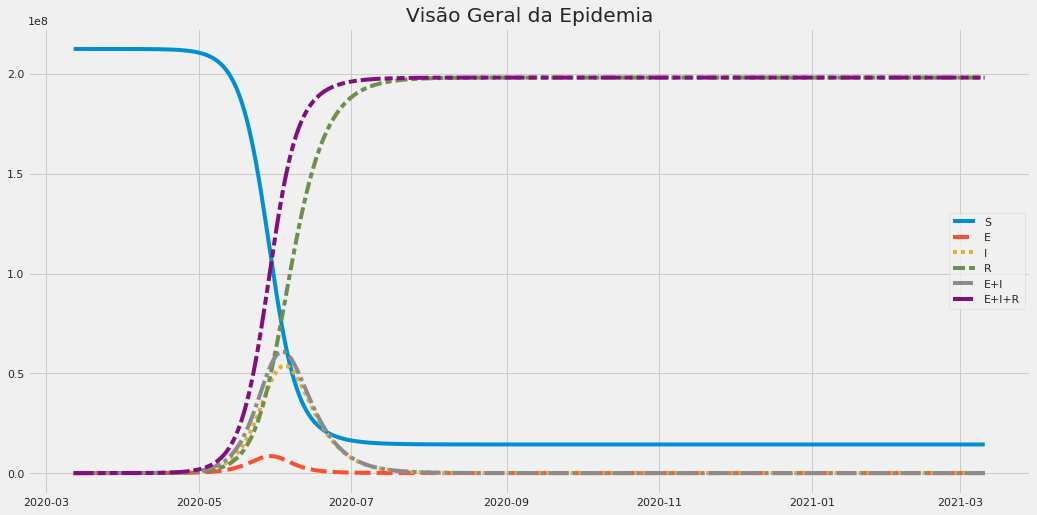

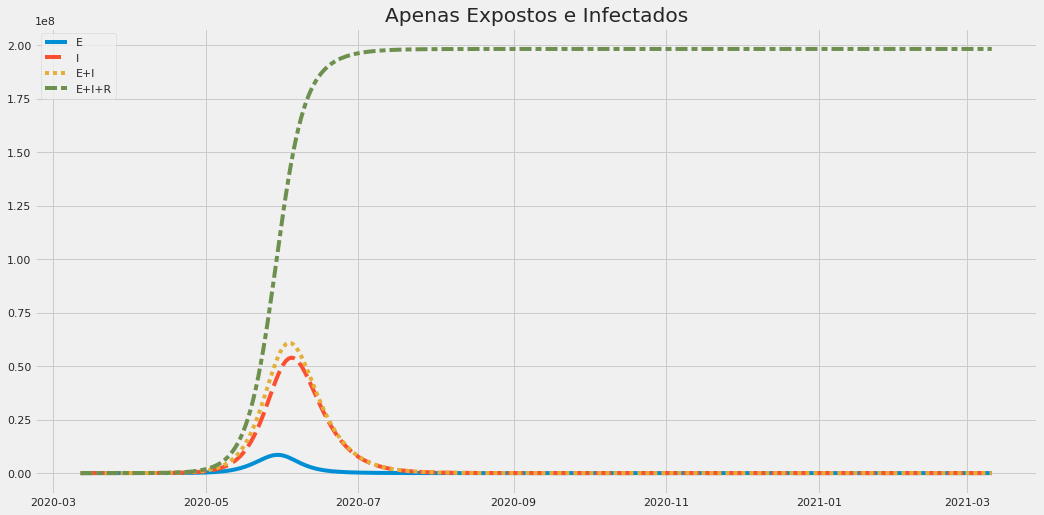

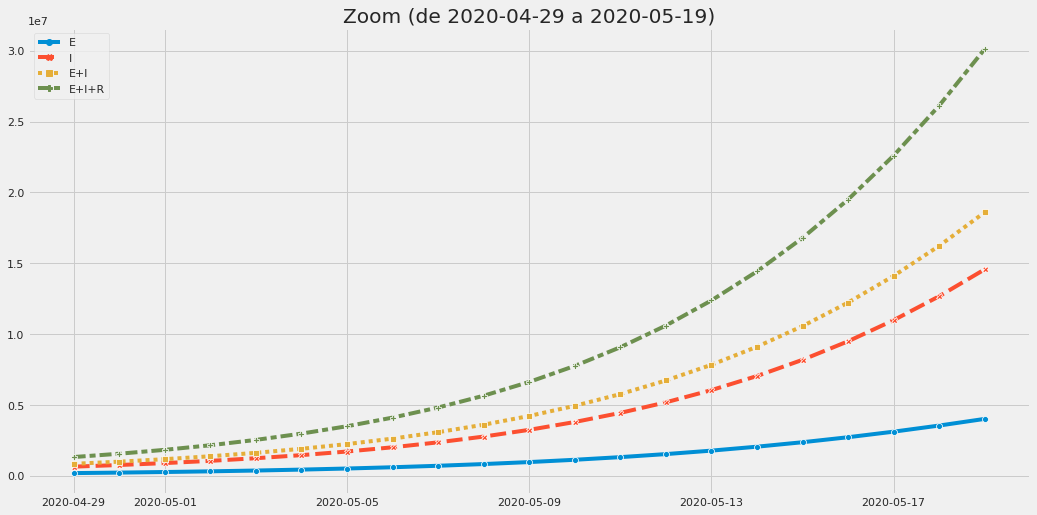

<Figure size 1152x576 with 0 Axes>

In [47]:
df_simulation_mitigation_data = simulate(S=population_size - initially_infected, 
                                          E=initially_infected,
                                          I=0,
                                          R=0, 
                                          alpha=alpha, beta=beta, gamma=gamma, 
                                          epidemic_start_date=epidemic_start_date, 
                                          epidemic_duration_in_days=epidemic_duration_in_days, 
                                          s_func=s, 
                                          e_func=e,
                                          i_func=i, 
                                          r_func=r,
                                          e_delta_func=e_delta,
                                          i_delta_func=i_delta,
                                          r_delta_func=r_delta)

plot_simulation_output(df_simulation_mitigation_data, zoom_on='2020-04-29', zoom_length=20, file_name='dynamic')

Como isso essa versão com mitigação se compara visualmente com os dados reais observados?

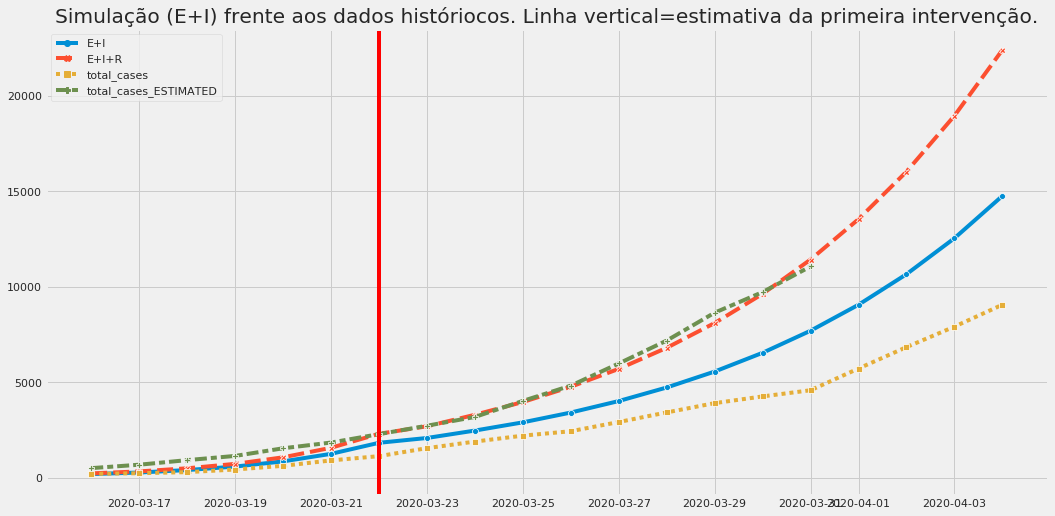

In [48]:
comparison_date = pd.Timestamp.today() - pd.DateOffset(days=3)
df_simulation_mitigated_vs_real = pd.concat([df_simulation_mitigation_data, df_data_target], axis=1)
ax = sns.lineplot(data=df_simulation_mitigated_vs_real[['E+I','E+I+R', 'total_cases', 'total_cases_ESTIMATED']]\
                                       [comparison_date - pd.DateOffset(days=20):comparison_date], 
             markers=True)

ax.set_title(f'Simulação (E+I) frente aos dados históriocos. Linha vertical=estimativa da primeira intervenção.')
intervention_date_1 = epidemic_start_date + pd.DateOffset(days=int(best['duration_1']))
plt.axvline(intervention_date_1, color='red')

ax.figure.savefig(results_folder + 'seir_dynamic_fit_zoom' + f'_{target_location.lower()}' + results_suffix + '.png', 
                  format='png')

Finalmente, comparemos os casos com e sem mitigação.

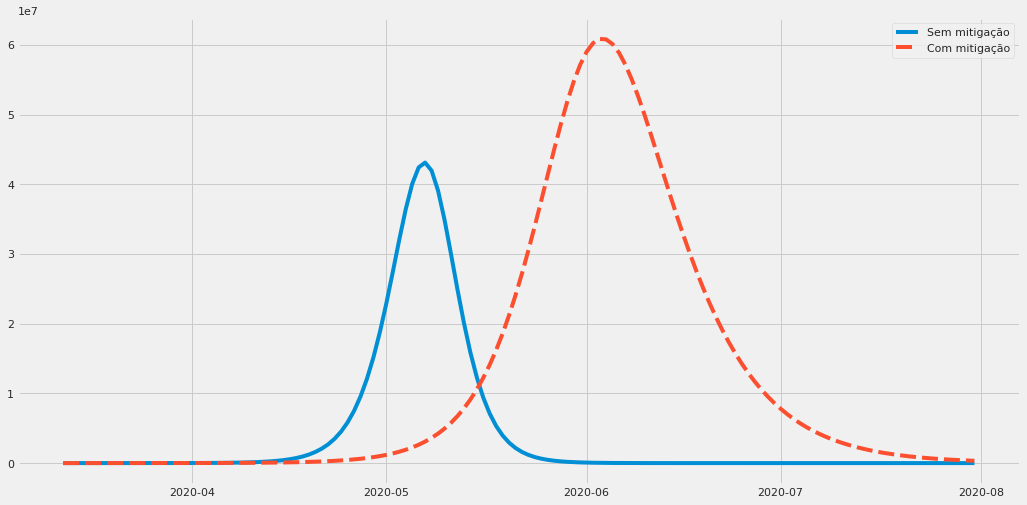

In [49]:
ax = sns.lineplot(data=pd.concat([df_simulation_data['E+I'].rename('Sem mitigação'), 
                                 df_simulation_mitigation_data['E+I'].rename('Com mitigação')], axis=1)['2020-03':'2020-07'])

ax.figure.savefig(results_folder + 'seir_constant_vs_dynamic' + f'_{target_location.lower()}' + results_suffix + '.png', 
                  format='png')

Salvemos os resultados.

In [50]:
df_simulation_mitigation_data.to_csv(results_folder + f'seir_dynamic_model_output.{target_location.lower()}.csv')